In [1]:
# Load necessary packages
# %pylab notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
# import scipy as sp
# from scipy.sparse import linalg as ln
from IPython.display import HTML
from random import choices
import math
import itertools
from os import path
from decimal import Decimal 
from scipy.optimize import curve_fit
from scipy import stats

# try:
#     plt.style.use('classic')
# except:
#     pass

# Use ODEINT to solve the differential equations defined by the vector field
# from scipy.integrate import odeint
# from scipy.integrate import solve_ivp

# Simulations and Results

At this point, we've given up on distribution-based simulation code and have gone back to the original FORTRAN code. 

In [2]:
heightRange = np.round(2**(np.unique(np.arange(8,18, 0.5))))
lambdaRange = 10**np.arange(-6, -1, 0.25).astype(float)

setRange = np.zeros((len(heightRange), len(lambdaRange),2))

for j in range(len(heightRange)): 
    for k in range(len(lambdaRange)): 
        setRange[j,k,0] = heightRange[j]
        setRange[j,k,1] = lambdaRange[k]
        
fixed_SetRange = setRange.transpose(2,0,1).reshape(2,-1)
print(np.shape(fixed_SetRange))

for i in range(len(fixed_SetRange[0,:])): 
    print(i+100, fixed_SetRange[0,i], fixed_SetRange[1,i])

(2, 400)
100 256.0 1e-06
101 256.0 1.778279410038923e-06
102 256.0 3.162277660168379e-06
103 256.0 5.623413251903491e-06
104 256.0 1e-05
105 256.0 1.778279410038923e-05
106 256.0 3.1622776601683795e-05
107 256.0 5.623413251903491e-05
108 256.0 0.0001
109 256.0 0.00017782794100389227
110 256.0 0.00031622776601683794
111 256.0 0.0005623413251903491
112 256.0 0.001
113 256.0 0.0017782794100389228
114 256.0 0.0031622776601683794
115 256.0 0.005623413251903491
116 256.0 0.01
117 256.0 0.01778279410038923
118 256.0 0.03162277660168379
119 256.0 0.05623413251903491
120 362.0 1e-06
121 362.0 1.778279410038923e-06
122 362.0 3.162277660168379e-06
123 362.0 5.623413251903491e-06
124 362.0 1e-05
125 362.0 1.778279410038923e-05
126 362.0 3.1622776601683795e-05
127 362.0 5.623413251903491e-05
128 362.0 0.0001
129 362.0 0.00017782794100389227
130 362.0 0.00031622776601683794
131 362.0 0.0005623413251903491
132 362.0 0.001
133 362.0 0.0017782794100389228
134 362.0 0.0031622776601683794
135 362.0 0.005

In [3]:
seed_counter = 100
for j in range(len(heightRange)): 
    print("    - `h_c`=", heightRange[j], "w/ `seed` =",seed_counter)
    for k in range(len(lambdaRange)): 
        seed_counter += 1

    - `h_c`= 256.0 w/ `seed` = 100
    - `h_c`= 362.0 w/ `seed` = 120
    - `h_c`= 512.0 w/ `seed` = 140
    - `h_c`= 724.0 w/ `seed` = 160
    - `h_c`= 1024.0 w/ `seed` = 180
    - `h_c`= 1448.0 w/ `seed` = 200
    - `h_c`= 2048.0 w/ `seed` = 220
    - `h_c`= 2896.0 w/ `seed` = 240
    - `h_c`= 4096.0 w/ `seed` = 260
    - `h_c`= 5793.0 w/ `seed` = 280
    - `h_c`= 8192.0 w/ `seed` = 300
    - `h_c`= 11585.0 w/ `seed` = 320
    - `h_c`= 16384.0 w/ `seed` = 340
    - `h_c`= 23170.0 w/ `seed` = 360
    - `h_c`= 32768.0 w/ `seed` = 380
    - `h_c`= 46341.0 w/ `seed` = 400
    - `h_c`= 65536.0 w/ `seed` = 420
    - `h_c`= 92682.0 w/ `seed` = 440
    - `h_c`= 131072.0 w/ `seed` = 460
    - `h_c`= 185364.0 w/ `seed` = 480


## Create SCC scripts to submit a job for given h_c

### Old runs (depracated)

In [16]:
def createScript(jobName, hc, lamb, seed):
    print("qsub" ,jobName+'.sh')
    filename = 'Scripts_fortran/' + jobName + '.sh'
    file = open(filename,"w+")

    file.write("#!/bin/bash -l \n \n" )

    file.write("# Set SCC Project \n")
    file.write("#$ -P bunuc \n")

    file.write("# Specify hard time limit for the job. \n")
    file.write("#   The job will be aborted if it runs longer than this time. \n")
    file.write("#$ -l h_rt=72:00:00 \n \n")

    file.write("# Reuest a node with at least 4 GB of memory per core \n")
    file.write("#$ -l mem_per_core=4G \n \n")

    file.write("# Request a paralell environemtn with _ cores \n")
    file.write("#$ -pe omp 1 \n \n")
    
    # ----- Assign Job Name -----
    file.write("# Give job a name \n")
    file.writelines(["#$ -N ", str(jobName), "\n \n"])

    file.write("# Combine output and error files into a single file \n")
    file.write("#$ -j y \n \n")
    
    file.write("# Specify the output file name \n")
    file.write("#$ -o results/"+jobname+"_out.txt \n \n")

    file.write("# Keep track of information related to the current job \n \n")
    
    file.write("declare -i timer=5000000 \n \n")
    file.write("declare -i L=128 \n \n")
    file.write("driv=1 \n \n")
    file.write("dissp="+str(lamb)+" \n \n")
    file.write("declare -i rand="+str(seed)+" \n \n")

    file.writelines(["echo -e \"$timer\\n$L\\n$dissp\\n$driv\\n$rand\" |  ./sandpile_"+str(int(hc))+" \n \n"])

    file.close()

heightRange = [128, 256, 512, 1024]
lambdaRange = np.logspace(-5, 0, 25).astype(float)

heightRange = []

setRange = np.zeros((len(heightRange), len(lambdaRange),2))

for j in range(len(heightRange)): 
    for k in range(len(lambdaRange)): 
        
        setRange[j,k,0] = heightRange[j]
        setRange[j,k,1] = lambdaRange[k]

fixed_SetRange = setRange.transpose(2,0,1).reshape(2,-1)
for j in range(len(fixed_SetRange[0,:])): 
#     print(fixed_SetRange[:,j])
    
    jobname = 'sp_' + str(11+j)
    createScript(jobname, fixed_SetRange[0,j], fixed_SetRange[1,j], 11+j)

qsub sp_11.sh
qsub sp_12.sh
qsub sp_13.sh
qsub sp_14.sh
qsub sp_15.sh
qsub sp_16.sh
qsub sp_17.sh
qsub sp_18.sh
qsub sp_19.sh
qsub sp_20.sh
qsub sp_21.sh
qsub sp_22.sh
qsub sp_23.sh
qsub sp_24.sh
qsub sp_25.sh
qsub sp_26.sh
qsub sp_27.sh
qsub sp_28.sh
qsub sp_29.sh
qsub sp_30.sh
qsub sp_31.sh
qsub sp_32.sh
qsub sp_33.sh
qsub sp_34.sh
qsub sp_35.sh
qsub sp_36.sh
qsub sp_37.sh
qsub sp_38.sh
qsub sp_39.sh
qsub sp_40.sh
qsub sp_41.sh
qsub sp_42.sh
qsub sp_43.sh
qsub sp_44.sh
qsub sp_45.sh
qsub sp_46.sh
qsub sp_47.sh
qsub sp_48.sh
qsub sp_49.sh
qsub sp_50.sh
qsub sp_51.sh
qsub sp_52.sh
qsub sp_53.sh
qsub sp_54.sh
qsub sp_55.sh
qsub sp_56.sh
qsub sp_57.sh
qsub sp_58.sh
qsub sp_59.sh
qsub sp_60.sh
qsub sp_61.sh
qsub sp_62.sh
qsub sp_63.sh
qsub sp_64.sh
qsub sp_65.sh
qsub sp_66.sh
qsub sp_67.sh
qsub sp_68.sh
qsub sp_69.sh
qsub sp_70.sh
qsub sp_71.sh
qsub sp_72.sh
qsub sp_73.sh
qsub sp_74.sh
qsub sp_75.sh
qsub sp_76.sh
qsub sp_77.sh
qsub sp_78.sh
qsub sp_79.sh
qsub sp_80.sh
qsub sp_81.sh
qsub s

In [7]:
def createScript(jobName, hc, lamb, seed):
    print("qsub" ,jobName+'.sh')
    filename = 'Scripts_fortran/' + jobName + '.sh'
    file = open(filename,"w+")

    file.write("#!/bin/bash -l \n \n" )

    file.write("# Set SCC Project \n")
    file.write("#$ -P bunuc \n")

    file.write("# Specify hard time limit for the job. \n")
    file.write("#   The job will be aborted if it runs longer than this time. \n")
    file.write("#$ -l h_rt=120:00:00 \n \n")

    file.write("# Reuest a node with at least 4 GB of memory per core \n")
    file.write("#$ -l mem_per_core=4G \n \n")

    file.write("# Request a paralell environemtn with _ cores \n")
    file.write("#$ -pe omp 1 \n \n")
    
    # ----- Assign Job Name -----
    file.write("# Give job a name \n")
    file.writelines(["#$ -N ", str(jobName), "\n \n"])

    file.write("# Combine output and error files into a single file \n")
    file.write("#$ -j y \n \n")
    
    file.write("# Specify the output file name \n")
    file.write("#$ -o results/"+jobname+"_out.txt \n \n")

    file.write("# Keep track of information related to the current job \n \n")
    
    file.write("declare -i timer=5000000 \n \n")
    file.write("declare -i L=1000 \n \n")
    file.write("driv=" +str(int(hc))+" \n \n")
    file.write("dissp="+str(lamb)+" \n \n")
    file.write("declare -i rand="+str(seed)+" \n \n")

    file.writelines(["echo -e \"$timer\\n$L\\n$dissp\\n$driv\\n$rand\" |  ./sandpile \n \n"])

    file.close()

heightRange = np.round(2**(np.unique(np.arange(1,11.5, 0.5))))
lambdaRange = np.logspace(-6, -1, 25).astype(float)

setRange = np.zeros((len(heightRange), len(lambdaRange),2))

for j in range(len(heightRange)): 
    for k in range(len(lambdaRange)): 
        setRange[j,k,0] = heightRange[j]
        setRange[j,k,1] = lambdaRange[k]
        
fixed_SetRange = setRange.transpose(2,0,1).reshape(2,-1)

print(heightRange)

for j in range(len(fixed_SetRange[0,:])): 
    jobname = 'sp_' + str(100+j)
#     print("qsub" ,jobname+'.sh')
#     createScript(jobname, fixed_SetRange[0,j], fixed_SetRange[1,j], 100+j)

[2.000e+00 3.000e+00 4.000e+00 6.000e+00 8.000e+00 1.100e+01 1.600e+01
 2.300e+01 3.200e+01 4.500e+01 6.400e+01 9.100e+01 1.280e+02 1.810e+02
 2.560e+02 3.620e+02 5.120e+02 7.240e+02 1.024e+03 1.448e+03 2.048e+03]


### New runs

In [3]:
def createScript(jobName, hc, lamb, seed):
    print("qsub" ,jobName+'.sh')
    filename = 'Scripts_fortran/' + jobName + '.sh'
    file = open(filename,"w+")

    file.write("#!/bin/bash -l \n \n" )

    file.write("# Set SCC Project \n")
    file.write("#$ -P bunuc \n")

    file.write("# Specify hard time limit for the job. \n")
    file.write("#   The job will be aborted if it runs longer than this time. \n")
    file.write("#$ -l h_rt=240:00:00 \n \n ")

    file.write("# Reuest a node with at least 4 GB of memory per core \n")
    file.write("#$ -l mem_per_core=4G \n \n")

    file.write("# Request a paralell environemtn with _ cores \n")
    file.write("#$ -pe omp 1 \n \n")
    
    # ----- Assign Job Name -----
    file.write("# Give job a name \n")
    file.writelines(["#$ -N ", str(jobName), "\n \n"])

    file.write("# Combine output and error files into a single file \n")
    file.write("#$ -j y \n \n")
    
    file.write("# Specify the output file name \n")
    file.write("#$ -o results/"+jobname+"_out.txt \n \n")

    file.write("# Keep track of information related to the current job \n \n")
    
    file.write("declare -i timer=5000000 \n \n")
    file.write("declare -i L=1000 \n \n")
    file.write("driv="+str(int(hc))+" \n \n")
    file.write("dissp="+str(lamb)+" \n \n")
    file.write("declare -i rand="+str(seed)+" \n \n")

    file.writelines(["echo -e \"$timer\\n$L\\n$dissp\\n$driv\\n$rand\" |  ./sandpile \n \n"])

    file.close()

heightRange = np.round(2**(np.unique(np.arange(8,17, 0.5))))
lambdaRange = 10**np.arange(-6, -1, 0.25).astype(float)


print(heightRange)
print(lambdaRange)


setRange = np.zeros((len(heightRange), len(lambdaRange),2))

for j in range(len(heightRange)): 
    for k in range(len(lambdaRange)): 
        setRange[j,k,0] = heightRange[j]
        setRange[j,k,1] = lambdaRange[k]

fixed_SetRange = setRange.transpose(2,0,1).reshape(2,-1)
for j in range(len(fixed_SetRange[0,:])): 
#     print(fixed_SetRange[:,j])
    
    jobname = 'sp_' + str(1000+j)
#     createScript(jobname, fixed_SetRange[0,j], fixed_SetRange[1,j], 1000+j)

[  256.   362.   512.   724.  1024.  1448.  2048.  2896.  4096.  5793.
  8192. 11585. 16384. 23170. 32768. 46341. 65536. 92682.]
[1.00000000e-06 1.77827941e-06 3.16227766e-06 5.62341325e-06
 1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04
 1.00000000e-03 1.77827941e-03 3.16227766e-03 5.62341325e-03
 1.00000000e-02 1.77827941e-02 3.16227766e-02 5.62341325e-02]


## Read-in Data from files 

In [11]:
# def readSizes(seed, filetype):
#     "Read the file of avalanche sizes for given seed. "
    
#     with open("Data_fortran/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
#         header=[x for x in next(f)]
#         params = [float(x) for x in next(f).split()]
#         array = [[int(x) for x in line.split() if '\x00' not in x ] for line in f]

#     sizeS_raw = [x[0] for x in array if len(x) >= 1]
#     params[1] = int(params[1])
#     return sizeS_raw, params

# def plotSizes(seed, filetype):
#     "Plot log-log size histogram (log-binned) "
#     sizeS, params = readSizes(seed,filetype)
#     sizeS_Log = np.asarray(sizeS)
#     hist, bin_edges = np.histogram(sizeS_Log,bins=np.logspace(0,25,50,base=2),density=True)
#     for i in range(len(hist)-1,-1,-1):      # Delete any 0 counts. 
#         if hist[i]==0:
#             hist = np.delete(hist,i)
#             bin_edges = np.delete(bin_edges,i)   
#     return bin_edges[:-1], hist, params

def plotSizes(seed, filetype):
    """
    Plot log-log size histogram (log-binned). Reads from pre-histogramed files""
    """
    filename = "Histo_fortran/sp_hist" + str(seed) + "_" + filetype + ".txt"
    
    ## Grab the parameters (first line, commented with '#')
    f=open(filename, "r")
    f1 = f.readlines()
    params = [float(i) for i in f1[0][1:].split(',')]
    
    ## Read the histogram array using Numpy commands. 
    z = np.loadtxt(filename, delimiter=',', comments='#')
    return z[:,0], z[:,1], params

## Determine seeds based on $h_c$.

In [14]:
## Determine which seeds satisfy the desired h_c
hc = heightRange[4]
indexRange = []
for j in range(len(fixed_SetRange[0,:])): 
    if fixed_SetRange[0,j] == hc:
        indexRange += [j+1000]
        
print(hc, ": ",indexRange)

1024.0 :  [1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099]


## Analaysis

### Plotting Distributions (test)

In [15]:
## Gather the histogram data for each of the runs (seeds in `indexRange`)
data_set = [] 
obs_type = "s"

for j_seed in indexRange: 

    obs_type = "s"
    data = plotSizes(j_seed, obs_type)

    x,y = data[0], data[1]
    x = np.log10(x); y = np.log10(y)

    data_set += [np.vstack((x, y))]

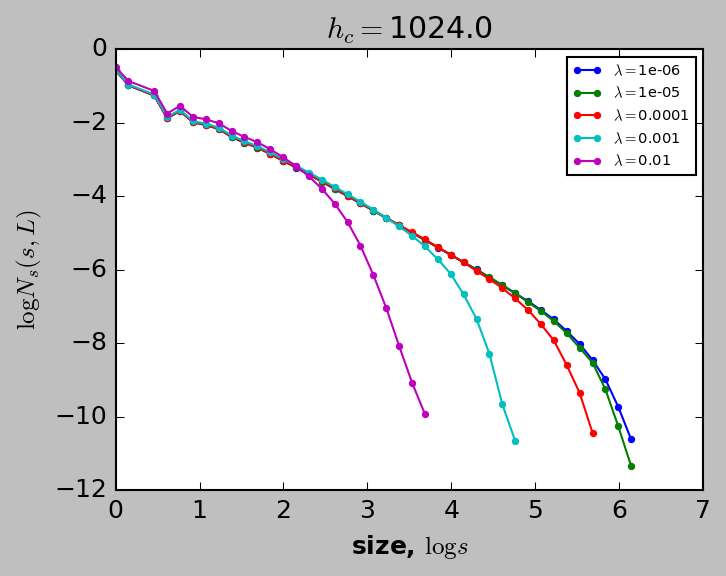

In [16]:
## Plot the data sets computed above. 
fig, ax1 = plt.subplots(1,1,figsize=(5, 4), dpi=150, frameon=True)

for j in range(len(data_set)): 
    if j%4==0:
        lamb = fixed_SetRange[1,j]
        x = data_set[j][0,:]
        y = data_set[j][1,:]
        ax1.plot(x, y, '.-', label = r"$\lambda=$"+str(round(lamb,6)))
    
ax1.legend(fontsize=7)
ax1.set_title(r"$h_c=$"+str(hc))
ax1.set_ylabel(r'$\log N_s(s,L)$',fontweight='bold'); 
ax1.set_xlabel('size, $\log s$',fontweight='bold')
fig.tight_layout()

### Compute $\tau$ exponents

Fit the power-law section of the scaling distributions to fit to a $\tau$ exponent. At the critical point, the distribution should take the form:
\begin{equation}
N_s \sim s^{-\tau}
\end{equation}

In [15]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[6:26], y[6:26], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[26],40)
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    ax1.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_s = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax1.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    
    # ---------------------------------------------------- #
    taus = round(-za[0],3)
    errors = round(perra[0], 4)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[6:23], y[6:23], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[23],40)
    ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    ax3.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax3.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    taua = round(-za[0],3)
    errora = round(perra[0], 4)
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    
    za, cova = np.polyfit(x[6:14], y[6:14], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[14],40)
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    ax2.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_D = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax2.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    taud = round(-za[0],3)
    errord = round(perra[0], 4)

    return params[2], params[3], [taus, taua, taud], [errors, errora, errord]

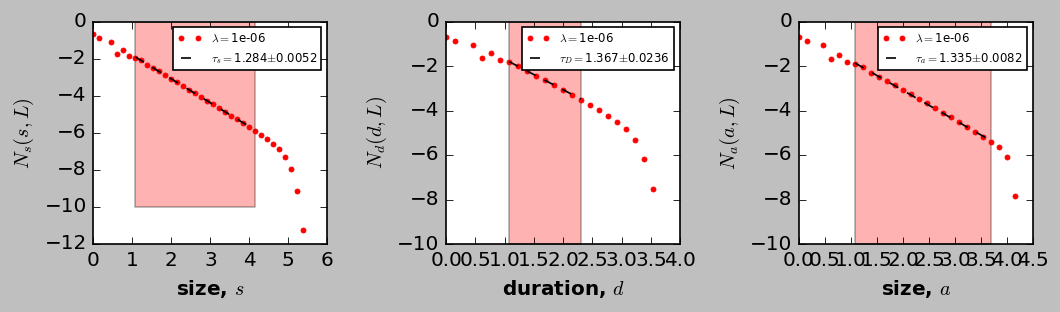

In [27]:
seed0 = indexRange[0] # Run/seed with smallest \lambda
print("Working on seed"+str(seed0)+"...", end='\r')

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,3), dpi=120, frameon=True)

lamb, h_c, new_exp, new_err = plotD_plotSizes(seed0, 'r')

tau_s = new_exp[0]
tau_a = new_exp[1]
tau_d = new_exp[2]
tau_s_err = new_err[0]
tau_a_err = new_err[1]
tau_d_err = new_err[2]

# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=1, fontsize=7)
ax2.legend(loc=1, fontsize=7)
ax3.legend(loc=1, fontsize=7)
# ax2.set_ylim(top=7)
# fig.suptitle("MM-OBC, $L=256$, $h_c = $"+str(h_c) + ", $\lambda= $"+str(lamb))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


### Compute $\sigma$ exponent

Based on the results from the previous section (where we computed the $\tau$ exponent), we now compute the $\sigma$ exponent. This is done by fitting the distributoin for each $\lambda$ to the form:
\begin{equation}
    N_s \sim s^{-\tau} \exp[-s/s_c]
\end{equation}

where
\begin{equation}
    s_c \sim \lambda^{-1/\sigma}
\end{equation}

We fit to compute $s_c(\lambda)$, then fit the second equation to a line (on a log-log scale). 

In [16]:
def func_sizeC(s, tau, s_c, A):
    return A - tau * s -  10**(s) / s_c / np.log(10)

def plotD_plotSizes(seed, c, tauList, tau_err, plotBool):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    tau = tauList[0]; er=tau_err[0]
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt, pcov = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr = np.sqrt(np.diag(pcov))

    if plotBool: 
        ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
        ax1.plot(x, func_sizeC(x, *popt), color=c)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    tau = tauList[1]; er=tau_err[1]
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt3, pcov3 = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr3 = np.sqrt(np.diag(pcov3))
    
    if plotBool: 
        ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
        ax3.plot(x, func_sizeC(x, *popt3), color=c)
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    tau = tauList[2]; er=tau_err[2]
    initGuess = np.asarray([tau, 1,    1])
    paramBounds =         ((tau-er, -1e8, -100), 
                           (tau+er, 1e8,  100))
    popt2, pcov2 = curve_fit(func_sizeC, x, y, p0=initGuess, bounds=paramBounds)
    perr2 = np.sqrt(np.diag(pcov2))

    if plotBool: 
        ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
        ax2.plot(x, func_sizeC(x, *popt2), color=c)
    return params[2], params[3], [popt[0], popt[1],popt2[0], popt2[1],popt3[0], popt3[1]], [perr[0], perr[1], perr2[0], perr2[1], perr3[0], perr3[1]]

In [29]:
sigma_s = []; sigma_a = []; sigma_d = []
sigma_s_err = []; sigma_a_err = []; sigma_d_err = []

lambdas = []
s_c = []; a_c = []; d_c = []

tauList = [tau_s, tau_a, tau_d]
tauErrList = [tau_s_err, tau_a_err, tau_d_err]

for i in range(len(indexRange[:-1])):
    c = 'r'
    print(indexRange[i], end=' ')
    lamb, h_c, new_exp, new_err = plotD_plotSizes(indexRange[i], c, tauList, tauErrList, plotBool=False)
    lambdas += [lamb]
    s_c += [new_exp[1]]
    a_c += [new_exp[5]]
    d_c += [new_exp[3]]

100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 

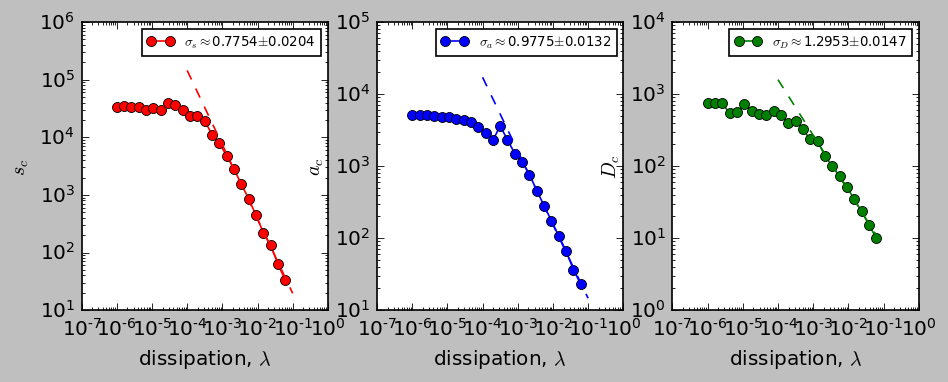

In [49]:
# ---------- Plot of Exponents while lambda -> 0 --------- #
# ---------- Fitting to compute \sigma's  ---------------- #

slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log10(np.asarray(lambdas[15:-1])), np.log10(np.asarray(s_c[15:-1])))
slopeA, interceptA, r_valueA, p_valueA, std_errA = stats.linregress(np.log10(np.asarray(lambdas[15:-1])), np.log10(np.asarray(a_c[15:-1])))
slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log10(np.asarray(lambdas[15:-1])), np.log10(np.asarray(d_c[15:-1])))

xs = np.linspace(-4,-1,7)
lineS = slopeS * xs + interceptS
lineA = slopeA * xs + interceptA
lineD = slopeD * xs + interceptD

sigma_s = -1/slopeS
sigma_a = -1/slopeA
sigma_d = -1/slopeD
sigma_s_err = std_errS
sigma_a_err = std_errA
sigma_d_err = std_errD

# -------------------- Create Figure  -------------------- #
fig2, (ax4, ax5, ax6) = plt.subplots(1,3,figsize=(9, 3), dpi=120, frameon=True)
ax4.plot(np.asarray(lambdas),np.asarray(s_c), 'ro-', 
         label=r'$\sigma_s \approx $' + str(round(-1/slopeS, 4)) + '$\pm$' + str(round(std_errS, 4)))
ax5.plot(np.asarray(lambdas),np.asarray(a_c),'bo-', 
         label=r'$\sigma_a \approx $' + str(round(-1/slopeA, 4)) + '$\pm$' + str(round(std_errA, 4)))
ax6.plot(np.asarray(lambdas),np.asarray(d_c),'go-', 
         label=r'$\sigma_D \approx $' + str(round(-1/slopeD, 4)) + '$\pm$' + str(round(std_errD, 4)))

# print(-1/slopeS, -1/slopeD)
ax4.plot(10**xs, 10**lineS, '--', color='red')
ax5.plot(10**xs, 10**lineA, '--', color='blue')
ax6.plot(10**xs, 10**lineD, '--', color='green')

# -- Decoration --
ax4.legend(fontsize=8); 
ax5.legend(fontsize=8); 
ax6.legend(fontsize=8); 
ax4.set_xscale('log'); ax4.set_yscale('log'); ax4.set_xlabel('dissipation, $\lambda$'); ax4.set_ylabel('$s_c$')
ax5.set_xscale('log'); ax5.set_yscale('log'); ax5.set_xlabel('dissipation, $\lambda$'); ax6.set_ylabel('$D_c$')
ax6.set_xscale('log'); ax6.set_yscale('log'); ax6.set_xlabel('dissipation, $\lambda$'); ax5.set_ylabel('$a_c$')
# fig2.suptitle("MM-OBC, $L=256$, $h_c = $"+str(h_c))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


### Mean cluster size $\chi(\lambda) \sim \lambda^{-\gamma}$

In [17]:
def calc_chi_disp(seed_list, filetype):
    chi_s = np.zeros_like(seed_list);  lambda_s = np.zeros_like(seed_list).astype('float')
    for s in range(len(seed_list)):
        print(seed_list[s], end=filetype+' ')
        sizeS, params = readSizes(seed_list[s],filetype)
        lambda_s[s] = params[2]
        chi_s[s] = np.sum(np.power(sizeS, 2)) / np.sum(np.power(sizeS, 1))
    return lambda_s, chi_s

def read_chi_disp(hc, filetype): 
    filename = "Data_fortran/chi_"+filetype+str(hc)+".txt"
    
    ## Read the histogram array using Numpy commands. 
    z = np.loadtxt(filename, delimiter=',', comments='#')
    return z[0,:], z[1,:]

In [36]:
lambda_s, chi_s = read_chi_disp(hc,'s')
lambda_a, chi_a = read_chi_disp(hc,'a')
lambda_d, chi_d = read_chi_disp(hc,'d')

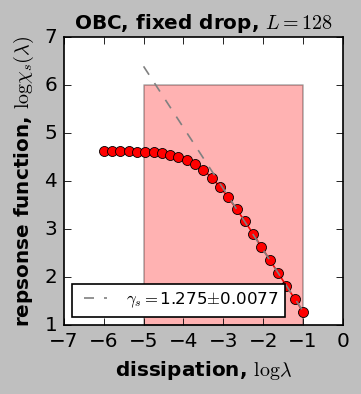

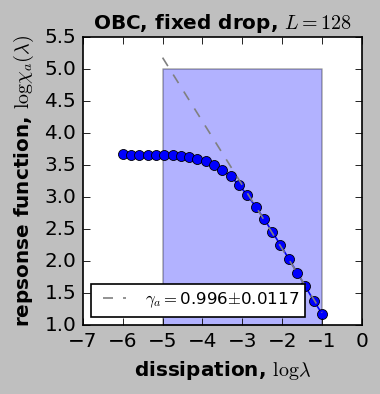

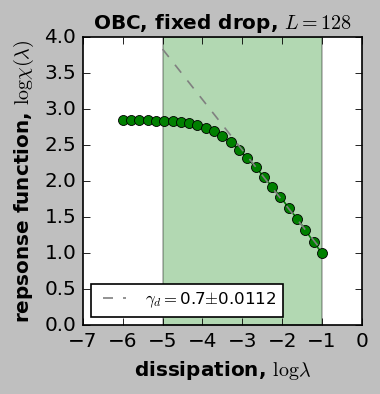

In [51]:
loglambd_s = np.log10(lambda_s); logchi_s = np.log10(chi_s)
loglambd_a = np.log10(lambda_a); logchi_a = np.log10(chi_a)

# -------------------- Create Figure  -------------------- #       
fig1, (ax1) = plt.subplots(1,1,figsize=(3,3), dpi=120, frameon=True)
fig2, (ax2) = plt.subplots(1,1,figsize=(3,3), dpi=120, frameon=True)
ax1.plot(loglambd_s, logchi_s, 'ro-')
ax2.plot(loglambd_a, logchi_a, 'bo-')

zs, covs = np.polyfit(loglambd_s[15:-1], logchi_s[15:-1], 1, cov=True)
ps = np.poly1d(zs)
perrs = np.sqrt(np.diag(covs))
xps = np.linspace(-5,-1,40)
ax1.plot(xps, ps(xps),linestyle='--', color='grey', 
         label='$\gamma_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
ax1.fill_between(xps, 1, 6, 
                facecolor='red', alpha=0.3)
gamma_s = -zs[0]

za, cova = np.polyfit(loglambd_a[15:-1], logchi_a[15:-1], 1, cov=True)
pa = np.poly1d(za)
perra = np.sqrt(np.diag(cova))
xpa = np.linspace(-5,-1,40)
ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
         label='$\gamma_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
ax2.fill_between(xps, 1, 5, 
                facecolor='blue', alpha=0.3)
gamma_a = -za[0]

# -- Decoration --
ax1.set_ylabel(r'repsonse function, $\log\chi_s(\lambda)$',fontweight='bold')
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3, fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
# ax1.set_ylim(bottom=np.min(logchi_s)-0.1, top=np.max(logchi_s)+0.1)

ax2.set_ylabel(r'repsonse function, $\log\chi_a(\lambda)$',fontweight='bold')
ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax2.legend(loc=3, fontsize=10)
ax2.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
# ax2.set_ylim(bottom=np.min(logchi_a)-0.1, top=np.max(logchi_a)+0.1)
# fig1.savefig("sp_crit_manna_chi_s", dpi=240)
# fig2.savefig("sp_crit_manna_chi_a", dpi=240)
plt.show()

loglambd_d = np.log10(lambda_d); logchi_d = np.log10(chi_d)

# -------------------- Create Figure  -------------------- #       
fig, (ax1) = plt.subplots(1,1,figsize=(3,3), dpi=120, frameon=True)
ax1.plot(loglambd_d, logchi_d, 'go-')

zd, covd = np.polyfit(loglambd_d[15:-1], logchi_d[15:-1], 1, cov=True)
pd = np.poly1d(zd)
perrd = np.sqrt(np.diag(covd))
xpd = np.linspace(-5,-1,40)
ax1.plot(xpd, pd(xpd),linestyle='--', color='grey', 
         label='$\gamma_d = $'+str(round(-zd[0],3))+'$\pm$'+str(round(perrd[0], 4)))
ax1.fill_between(xpd, 0, 4, #where=y > theta,
                facecolor='green', alpha=0.3)
gamma_d = -zd[0]

# -- Decoration --
ax1.set_ylabel(r'repsonse function, $\log\chi(\lambda)$',fontweight='bold')
ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
ax1.legend(loc=3, fontsize=10)
ax1.set_title("OBC, fixed drop, $L = 128$", fontsize=12, fontweight='bold')
# ax1.set_ylim(bottom=np.min(logchi_d)-0.1, top=np.max(logchi_d)+0.1)

# plt.savefig("sp_crit_manna_chi_d", dpi=240)
plt.show()


## Exponent Check

What are all the exponents? 

Scaling relation? $\gamma = 1/\sigma$. 

In [39]:
print("hc = ", hc)

print('tau_s = ', tau_s)
print('tau_a = ', tau_a)
print('tau_d = ', tau_d)

hc =  2
tau_s =  1.284
tau_a =  1.335
tau_d =  1.367


In [40]:
print('sigma_s = ', round(sigma_s, 4))
print('sigma_a = ', round(sigma_a, 4))
print('sigma_d = ', round(sigma_d, 4))

sigma_s =  1.0301
sigma_a =  1.4103
sigma_d =  1.8225


In [50]:
print('gamma_s = ', round(gamma_s,4), "=?",round(1/sigma_s, 4))
print('gamma_a = ', round(gamma_a,4), "=?",round(1/sigma_a, 4))
print('gamma_d = ', round(gamma_d,4), "=?",round(1/sigma_d, 4))

gamma_s =  1.275 =? 1.2897
gamma_a =  0.996 =? 1.023
gamma_d =  0.7005 =? 0.772


# Compute all exponents vs. $h_c$

In [4]:
heightRange = np.round(2**(np.unique(np.arange(8,17, 0.5))))
lambdaRange = 10**np.arange(-6, -1, 0.25).astype(float)

setRange = np.zeros((len(heightRange), len(lambdaRange),2))

for j in range(len(heightRange)): 
    for k in range(len(lambdaRange)): 
        setRange[j,k,0] = heightRange[j]
        setRange[j,k,1] = lambdaRange[k]

fixed_SetRange = setRange.transpose(2,0,1).reshape(2,-1)
print(np.shape(fixed_SetRange))


## Determine which seeds satisfy the desired h_c
hc = 256
indexRange = []
for j in range(len(fixed_SetRange[0,:])): 
    if fixed_SetRange[0,j] == hc:
        indexRange += [j+1000]
        
print(indexRange)
print(heightRange)


(2, 360)
[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019]
[  256.   362.   512.   724.  1024.  1448.  2048.  2896.  4096.  5793.
  8192. 11585. 16384. 23170. 32768. 46341. 65536. 92682.]


## Functions

In [5]:
def plotSizes(seed, filetype):
    """
    Plot log-log size histogram (log-binned). Reads from pre-histogramed files""
    """
    filename = "Histo_fortran/sp_hist" + str(seed) + "_" + filetype + ".txt"
    
    ## Grab the parameters (first line, commented with '#')
    f=open(filename, "r")
    f1 = f.readlines()
    params = [float(i) for i in f1[0][1:].split(',')]
    
    ## Read the histogram array using Numpy commands. 
    z = np.loadtxt(filename, delimiter=',', comments='#')
    return z[:,0], z[:,1], params

def plotD_tau(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[8:26], y[8:26], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[26],40)
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    ax1.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_s = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax1.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    
    # ---------------------------------------------------- #
    taus = round(-za[0],3)
    errors = round(perra[0], 4)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[6:23], y[6:23], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[23],40)
    ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    ax3.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax3.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    taua = round(-za[0],3)
    errora = round(perra[0], 4)
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    
    za, cova = np.polyfit(x[6:14], y[6:14], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[14],40)
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    ax2.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_D = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax2.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    taud = round(-za[0],3)
    errord = round(perra[0], 4)

    return params[2], params[3], [taus, taua, taud], [errors, errora, errord]

def func_sizeC(s, tau, s_c, A):
    return A - tau * s -  10**(s) / s_c / np.log(10)

def plotD_plotSizes(seed, c, tauList, tau_err, plotBool):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    tau = tauList[0]; er=tau_err[0]
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt, pcov = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr = np.sqrt(np.diag(pcov))

    if plotBool: 
        ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
        ax1.plot(x, func_sizeC(x, *popt), color=c)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    tau = tauList[1]; er=tau_err[1]
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt3, pcov3 = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr3 = np.sqrt(np.diag(pcov3))
    
    if plotBool: 
        ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
        ax3.plot(x, func_sizeC(x, *popt3), color=c)
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    tau = tauList[2]; er=tau_err[2]
    initGuess = np.asarray([tau, 1,    1])
    paramBounds =         ((tau-er, -1e8, -100), 
                           (tau+er, 1e8,  100))
    popt2, pcov2 = curve_fit(func_sizeC, x, y, p0=initGuess, bounds=paramBounds)
    perr2 = np.sqrt(np.diag(pcov2))

    if plotBool: 
        ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
        ax2.plot(x, func_sizeC(x, *popt2), color=c)
    return params[2], params[3], [popt[0], popt[1],popt2[0], popt2[1],popt3[0], popt3[1]], [perr[0], perr[1], perr2[0], perr2[1], perr3[0], perr3[1]]

def read_chi_disp(hc, filetype): 
    filename = "Histo_fortran/chi_"+filetype+str(hc)+".txt"
    
    ## Read the histogram array using Numpy commands. 
    z = np.loadtxt(filename, delimiter=',', comments='#')
    return z[0,:], z[1,:]

## Compute $\tau$

In [14]:
tau_s = []
tau_a = []
tau_d = []
tau_s_err = []
tau_a_err = []
tau_d_err = []

for hc in heightRange: 
    indexRange = []
    for j in range(len(fixed_SetRange[0,:])): 
        if fixed_SetRange[0,j] == hc:
            filename = "Histo_fortran/sp_hist" + str(j+1000) + "_s.txt"
            if path.exists(filename):
                indexRange += [j+1000] 
                
    seed0 = indexRange[0] # Run/seed with smallest \lambda
    print("Working on seed"+str(seed0)+"...", end='\r')

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,3), dpi=120, frameon=True)

    lamb, h_c, new_exp, new_err = plotD_tau(seed0, 'r')

    tau_s += [new_exp[0]]
    tau_a += [new_exp[1]]
    tau_d += [new_exp[2]]
    tau_s_err += [new_err[0]]
    tau_a_err += [new_err[1]]
    tau_d_err += [new_err[2]]

    # -- Decoration --
    ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
    ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
    ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
    ax1.legend(loc=1, fontsize=7)
    ax2.legend(loc=1, fontsize=7)
    ax3.legend(loc=1, fontsize=7)
    ax2.set_title(r"$h_c=$"+str(hc))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("Plots_fortran/hc"+str(hc)+"_tau_x.png", dpi=240, bbox_inches='tight')
    plt.close()



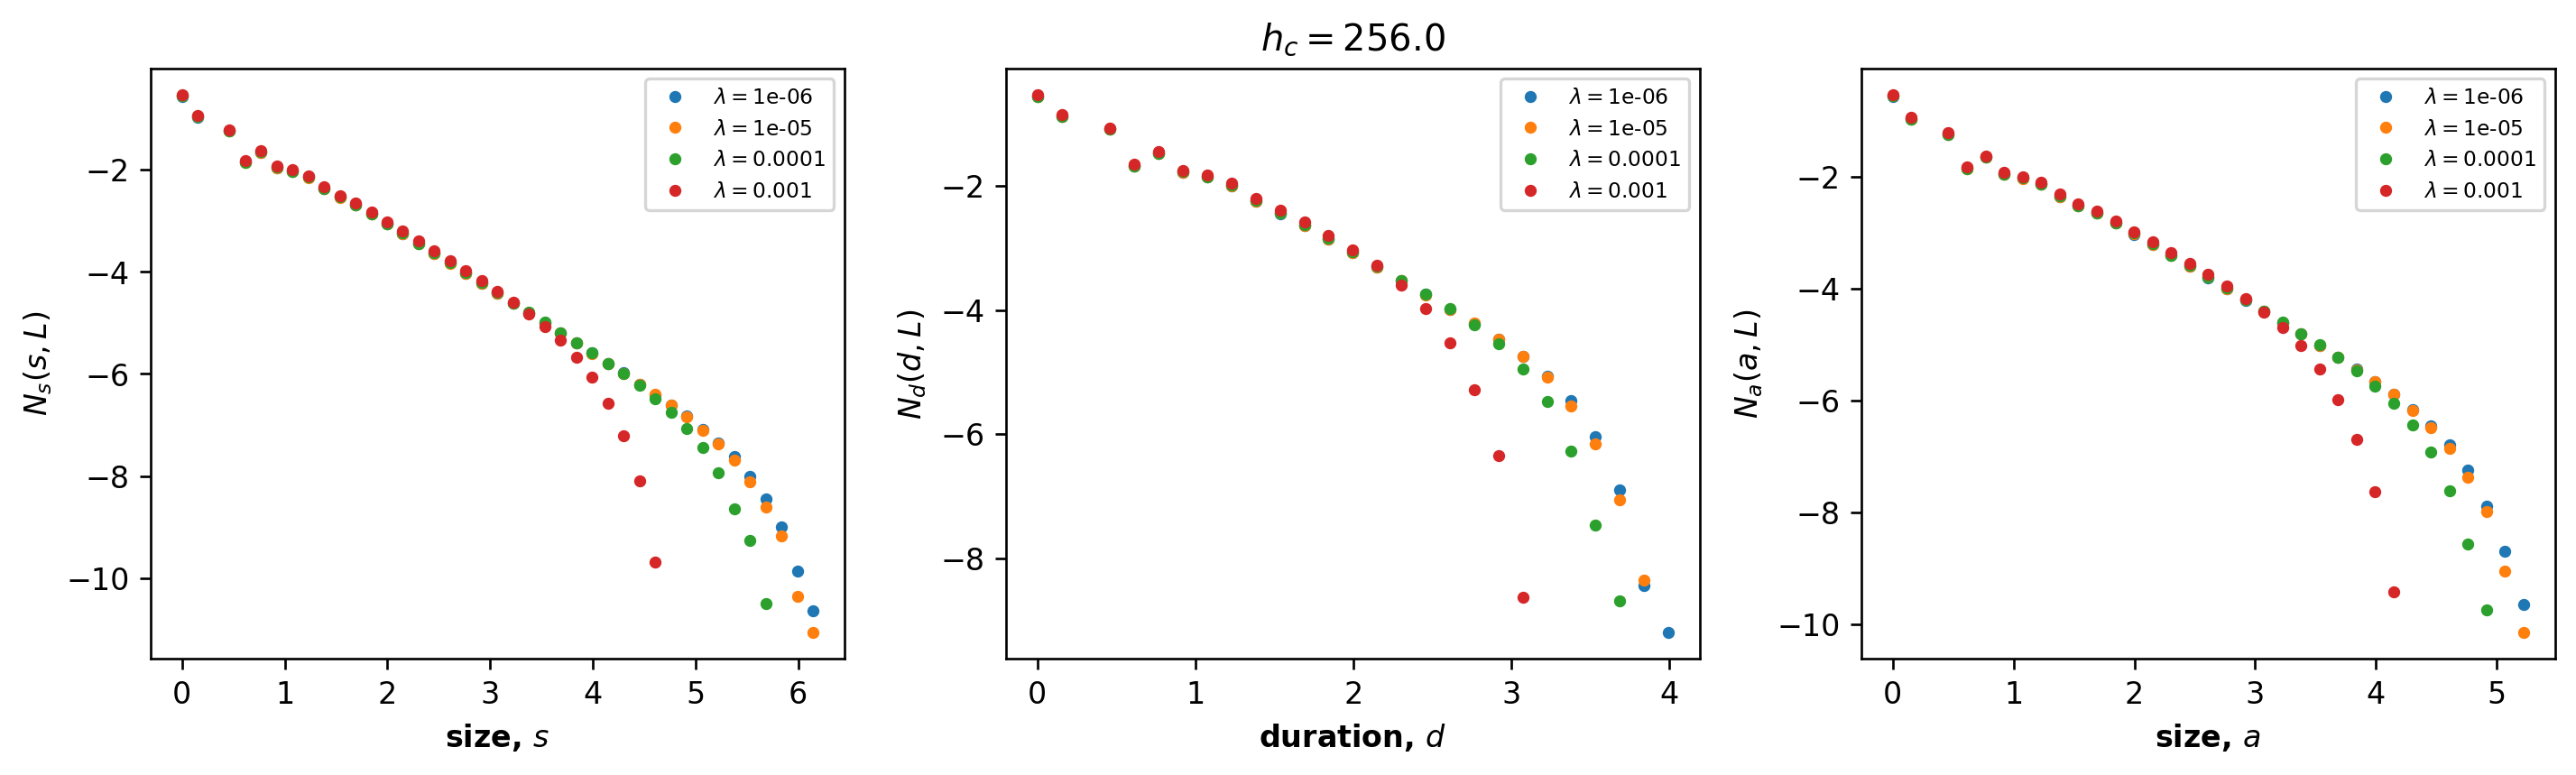

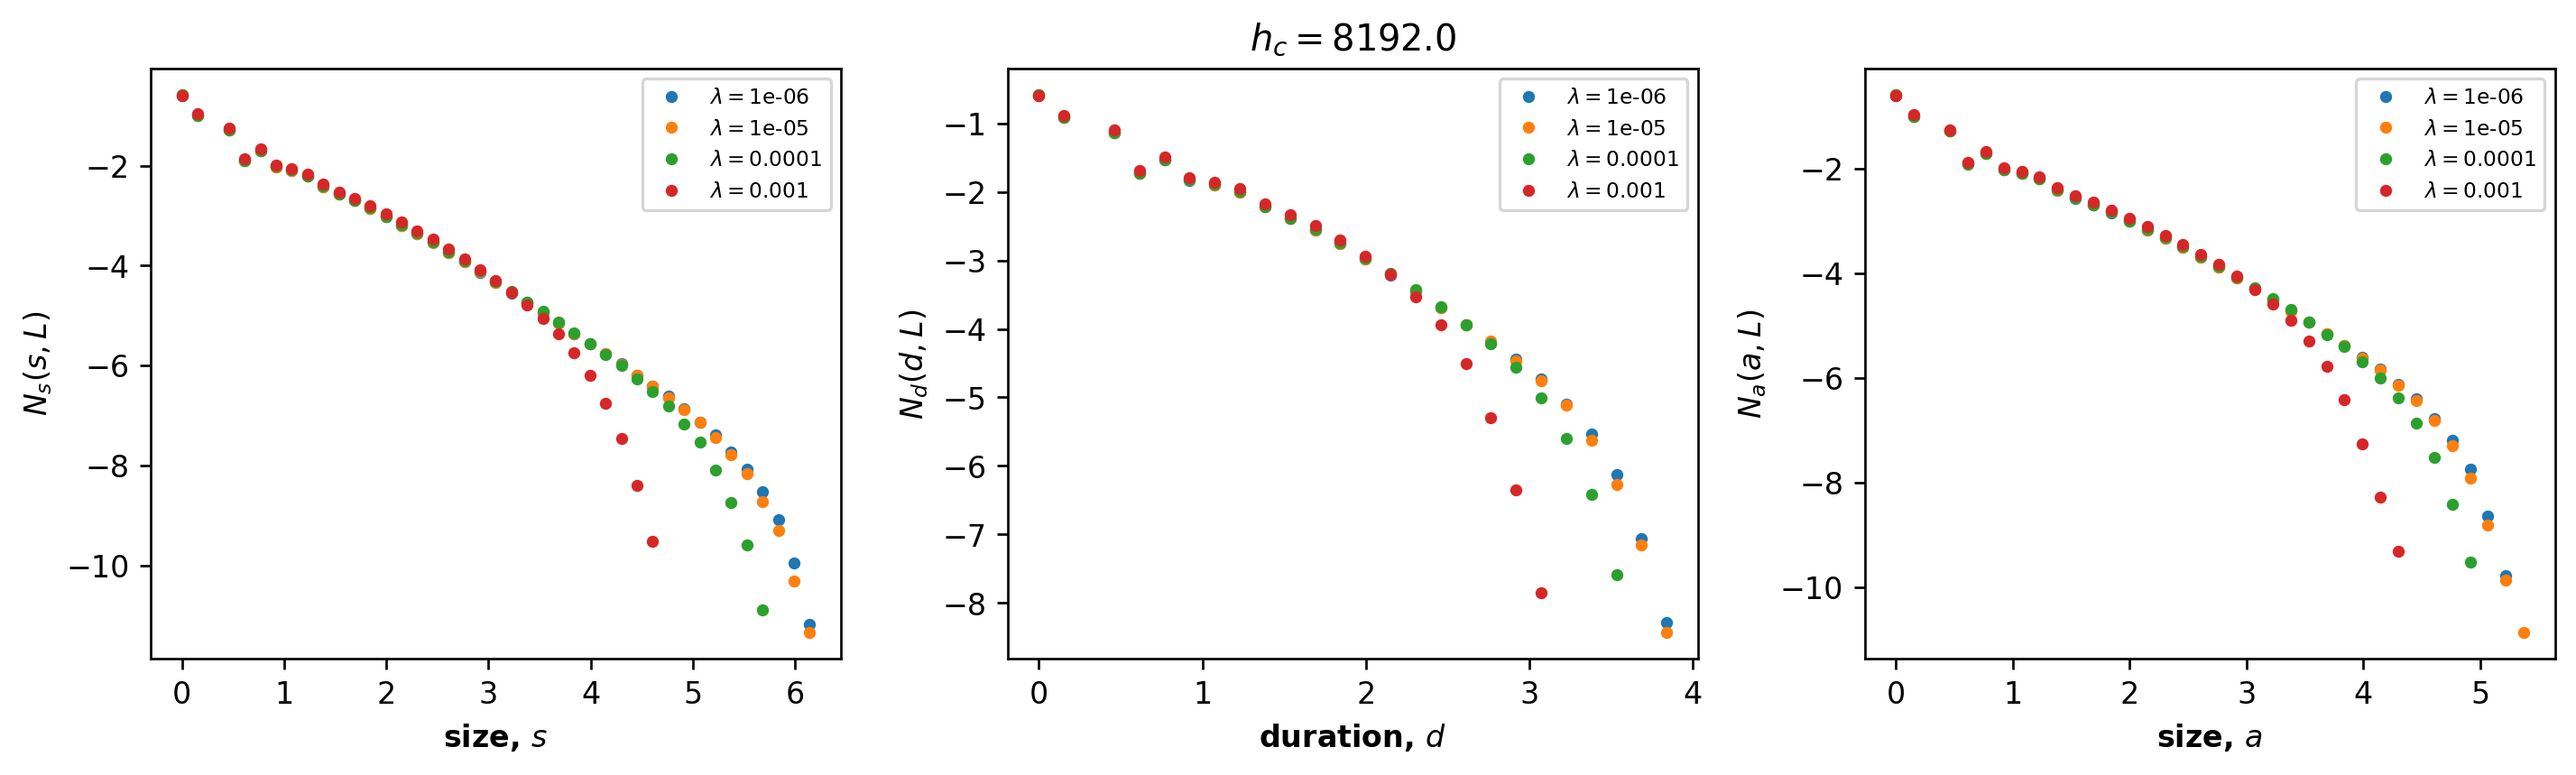

In [10]:
for hc in heightRange[::10]:
    indexRange = []
    for j in range(len(fixed_SetRange[0,:])): 
        if fixed_SetRange[0,j] == hc:
            filename = "Histo_fortran/sp_hist" + str(j+1000) + "_s.txt"
            if path.exists(filename):
                indexRange += [j+1000] 
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4), dpi=240, frameon=False)
    for seed_i, seed in enumerate(indexRange[:-4:4]): 
        
        ## Sizes w/ double counting
        x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
        ax1.plot(x, y, '.', label = r"$\lambda=$"+str(round(params[2],6)))

        ## Sizes w/o double counting
        x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
        ax3.plot(x, y, '.', label = r"$\lambda=$"+str(round(params[2],6)))

        ## Durations
        x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
        ax2.plot(x, y, '.', label = r"$\lambda=$"+str(round(params[2],6)))

    # -- Decoration --
    ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
    ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
    ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
    ax1.legend(loc=1, fontsize=7)
    ax2.legend(loc=1, fontsize=7)
    ax3.legend(loc=1, fontsize=7)
    ax2.set_title(r"$h_c=$"+str(hc))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig("Plots_fortran/hc"+str(hc)+"_tau_x.png", dpi=240, bbox_inches='tight')
#     plt.close()


## Compute $\sigma$

In [15]:
sigma_s = []
sigma_a = []
sigma_d = []
sigma_s_err = [] 
sigma_a_err = []
sigma_d_err = []


for hc_i, hc in enumerate(heightRange): 
    print(hc, end=' ')
    indexRange = []
    for j in range(len(fixed_SetRange[0,:])): 
        if fixed_SetRange[0,j] == hc:
            filename = "Histo_fortran/sp_hist" + str(j+1000) + "_s.txt"
            if path.exists(filename):
                indexRange += [j+1000] 

    lambdas = []
    s_c = []; a_c = []; d_c = []

    tauList = [tau_s[hc_i], tau_a[hc_i], tau_d[hc_i]]
    tauErrList = [tau_s_err[hc_i], tau_a_err[hc_i], tau_d_err[hc_i]]

    for i in range(len(indexRange[:-1])):
        c = 'r'
        lamb, h_c, new_exp, new_err = plotD_plotSizes(indexRange[i], c, tauList, tauErrList, plotBool=False)
        lambdas += [lamb]
        s_c += [new_exp[1]]
        a_c += [new_exp[5]]
        d_c += [new_exp[3]]

    # ---------- Plot of Exponents while lambda -> 0 --------- #
    # ---------- Fitting to compute \sigma's  ---------------- #
    fit_min = 9
    fit_max=-5

    slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log10(np.asarray(lambdas[fit_min:fit_max])), np.log10(np.asarray(s_c[fit_min:fit_max])))
    slopeA, interceptA, r_valueA, p_valueA, std_errA = stats.linregress(np.log10(np.asarray(lambdas[fit_min:fit_max])), np.log10(np.asarray(a_c[fit_min:fit_max])))
    slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log10(np.asarray(lambdas[fit_min:fit_max])), np.log10(np.asarray(d_c[fit_min:fit_max])))

    xs = np.linspace(-4,-1,7)
    lineS = slopeS * xs + interceptS
    lineA = slopeA * xs + interceptA
    lineD = slopeD * xs + interceptD

    sigma_s += [-1/slopeS]
    sigma_a += [-1/slopeA]
    sigma_d += [-1/slopeD]
    sigma_s_err += [std_errS]
    sigma_a_err += [std_errA]
    sigma_d_err += [std_errD]

    # -------------------- Create Figure  -------------------- #
    fig2, (ax4, ax5, ax6) = plt.subplots(1,3,figsize=(9, 3), dpi=120, frameon=True)
    ax4.plot(np.asarray(lambdas),np.asarray(s_c), 'ro-', 
             label=r'$\sigma_s \approx $' + str(round(-1/slopeS, 4)) + '$\pm$' + str(round(std_errS, 4)))
    ax5.plot(np.asarray(lambdas),np.asarray(a_c),'bo-', 
             label=r'$\sigma_a \approx $' + str(round(-1/slopeA, 4)) + '$\pm$' + str(round(std_errA, 4)))
    ax6.plot(np.asarray(lambdas),np.asarray(d_c),'go-', 
             label=r'$\sigma_D \approx $' + str(round(-1/slopeD, 4)) + '$\pm$' + str(round(std_errD, 4)))

    # print(-1/slopeS, -1/slopeD)
    ax4.plot(10**xs, 10**lineS, '--', color='grey')
    ax5.plot(10**xs, 10**lineA, '--', color='grey')
    ax6.plot(10**xs, 10**lineD, '--', color='grey')
    
    
    ax4.fill_between(lambdas[fit_min:fit_max], 1e1, 1e5, facecolor='red', alpha=0.3)
    ax5.fill_between(lambdas[fit_min:fit_max], 1e1, 1e5, facecolor='blue', alpha=0.3)
    ax6.fill_between(lambdas[fit_min:fit_max], 1e1, 1e5, facecolor='green', alpha=0.3)

    # -- Decoration --
    ax4.legend(fontsize=8); 
    ax5.legend(fontsize=8); 
    ax6.legend(fontsize=8); 
    ax4.set_xscale('log'); ax4.set_yscale('log'); ax4.set_xlabel('dissipation, $\lambda$'); ax4.set_ylabel('$s_c$')
    ax5.set_xscale('log'); ax5.set_yscale('log'); ax5.set_xlabel('dissipation, $\lambda$'); ax6.set_ylabel('$D_c$')
    ax6.set_xscale('log'); ax6.set_yscale('log'); ax6.set_xlabel('dissipation, $\lambda$'); ax5.set_ylabel('$a_c$')
    ax5.set_title(r"$h_c=$"+str(hc))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("Plots_fortran/hc"+str(hc)+"_sigma_x.png", dpi=240, bbox_inches='tight')
    plt.close()


256.0 362.0 512.0 724.0 1024.0 1448.0 2048.0 2896.0 4096.0 5793.0 8192.0 11585.0 16384.0 23170.0 32768.0 46341.0 65536.0 92682.0 

## Compute $\gamma$

In [16]:
gamma_s = []
gamma_a = []
gamma_d = []
gamma_s_err = []
gamma_a_err = []
gamma_d_err = []

for hc in heightRange: 
    print(hc, end=' ')
    
    fit_min = 9
    fit_max= -5

    lambda_s, chi_s = read_chi_disp(hc,'s')
    lambda_a, chi_a = read_chi_disp(hc,'a')
    lambda_d, chi_d = read_chi_disp(hc,'d')

    loglambd_s = np.log10(lambda_s); logchi_s = np.log10(chi_s)
    loglambd_a = np.log10(lambda_a); logchi_a = np.log10(chi_a)

    # -------------------- Create Figure  -------------------- #       
    fig1, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4), dpi=120, frameon=True)
    ax1.plot(loglambd_s, logchi_s, 'ro-')
    ax2.plot(loglambd_a, logchi_a, 'bo-')

    zs, covs = np.polyfit(loglambd_s[fit_min:fit_max], logchi_s[fit_min:fit_max], 1, cov=True)
    ps = np.poly1d(zs)
    perrs = np.sqrt(np.diag(covs))
    xps = np.linspace(-5,-1,40)
    ax1.plot(xps, ps(xps),linestyle='--', color='grey', 
             label='$\gamma_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
    ax1.fill_between(loglambd_a[fit_min:fit_max], 1, 6, 
                    facecolor='red', alpha=0.3)
    gamma_s += [-zs[0]]
    gamma_s_err += [round(perrs[0], 4)]

    za, cova = np.polyfit(loglambd_a[fit_min:fit_max], logchi_a[fit_min:fit_max], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(-5,-1,40)
    ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label='$\gamma_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax2.fill_between(loglambd_a[fit_min:fit_max], 1, 5, 
                    facecolor='blue', alpha=0.3)
    gamma_a += [-za[0]]
    gamma_a_err += [round(perra[0], 4)]

    # -- Decoration --
    ax1.set_ylabel(r'repsonse function, $\log\chi_s(\lambda)$',fontweight='bold')
    ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
    ax1.legend(loc=3, fontsize=8)

    ax2.set_ylabel(r'repsonse function, $\log\chi_a(\lambda)$',fontweight='bold')
    ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
    ax2.legend(loc=3, fontsize=8)

    loglambd_d = np.log10(lambda_d); logchi_d = np.log10(chi_d)

    # -------------------- Create Figure  -------------------- #       
    ax3.plot(loglambd_d, logchi_d, 'go-')

    zd, covd = np.polyfit(loglambd_d[fit_min:fit_max], logchi_d[fit_min:fit_max], 1, cov=True)
    pd = np.poly1d(zd)
    perrd = np.sqrt(np.diag(covd))
    xpd = np.linspace(-5,-1,40)
    ax3.plot(xpd, pd(xpd),linestyle='--', color='grey', 
             label='$\gamma_d = $'+str(round(-zd[0],3))+'$\pm$'+str(round(perrd[0], 4)))
    ax3.fill_between(loglambd_a[fit_min:fit_max], 0, 4, #where=y > theta,
                    facecolor='green', alpha=0.3)
    gamma_d += [-zd[0]]
    gamma_d_err += [round(perrd[0], 4)]

    # -- Decoration --
    ax3.set_ylabel(r'repsonse function, $\log\chi(\lambda)$',fontweight='bold')
    ax3.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
    ax3.legend(loc=3, fontsize=8)
    
    ax2.set_title(r"$h_c=$"+str(hc))
    
    plt.savefig("Plots_fortran/hc"+str(hc)+"_gamma_x.png", dpi=240, bbox_inches='tight')
    plt.close()



256.0 362.0 512.0 724.0 1024.0 1448.0 2048.0 2896.0 4096.0 5793.0 8192.0 11585.0 16384.0 23170.0 32768.0 46341.0 65536.0 92682.0 

## Compute $\nu$ - Correlation length 

$$\xi \sim \lambda^{-\nu}$$

In [17]:
def read_xi_disp(hc, filetype): 
    filename = "Histo_fortran/xi_"+filetype+str(hc)+".txt"
    
    ## Read the histogram array using Numpy commands. 
    z = np.loadtxt(filename, delimiter=',', comments='#')
    return z[0,:], z[1,:]

In [55]:
nu_s = []
nu_a = []
nu_s_err = []
nu_a_err = []

for hc in heightRange: 
    print(hc, end=' ')
    
    fit_min = 5
    fit_max= -4

    lambda_s, xi_s = read_xi_disp(hc,'s')
    lambda_a, xi_a = read_xi_disp(hc,'a')

    loglambd_s = np.log10(lambda_s); logxi_s = np.log10(xi_s)
    loglambd_a = np.log10(lambda_a); logxi_a = np.log10(xi_a)

    # -------------------- Create Figure  -------------------- #       
    fig1, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3), dpi=120, frameon=True)
    ax1.plot(loglambd_s, logxi_s, 'ro-')
    ax2.plot(loglambd_a, logxi_a, 'bo-')

    zs, covs = np.polyfit(loglambd_s[fit_min:fit_max], logxi_s[fit_min:fit_max], 1, cov=True)
    ps = np.poly1d(zs)
    perrs = np.sqrt(np.diag(covs))
    xps = np.linspace(-5,-1,40)
    ax1.plot(xps, ps(xps),linestyle='--', color='grey', 
             label='$\gamma_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
#     ax1.fill_between(loglambd_a[fit_min:fit_max], 1, 6, 
#                     facecolor='red', alpha=0.3)
    nu_s += [-zs[0]]
    nu_s_err += [round(perrs[0], 4)]

    za, cova = np.polyfit(loglambd_a[fit_min:fit_max], logxi_a[fit_min:fit_max], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(-5,-1,40)
    ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label='$\gamma_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
#     ax2.fill_between(loglambd_a[fit_min:fit_max], 1, 5, 
#                     facecolor='blue', alpha=0.3)
    nu_a += [-za[0]]
    nu_a_err += [round(perra[0], 4)]

    # -- Decoration --
    ax1.set_ylabel(r'correlation length, $\log\xi_s(\lambda)$',fontweight='bold')
    ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
    ax1.legend(loc=3, fontsize=8)

    ax2.set_ylabel(r'correlation length, $\log\xi_a(\lambda)$',fontweight='bold')
    ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
    ax2.legend(loc=3, fontsize=8)
    
    ax2.set_title(r"$h_c=$"+str(hc))
    
    plt.savefig("Plots_fortran/hc"+str(hc)+"_nu_x.png", dpi=240, bbox_inches='tight')
    plt.close()




256.0 362.0 512.0 724.0 1024.0 1448.0 2048.0 2896.0 4096.0 5793.0 8192.0 11585.0 16384.0 23170.0 32768.0 46341.0 65536.0 92682.0 

## Average Size vs. Duration; $\langle s \rangle \sim D^{1/\sigma\nu z}$

In [19]:
def plot_DurSizes(seed, filetype):
    """
    Plot log-log size histogram (log-binned). Reads from pre-histogramed files""
    """
    if filetype=="a":
        filename = "Histo_fortran/dur_area" + str(seed) + ".txt"
    else: 
        filename = "Histo_fortran/dur_size" + str(seed) + ".txt"
    
    ## Grab the parameters (first line, commented with '#')
    f=open(filename, "r")
    f1 = f.readlines()
    params = [float(i) for i in f1[0][1:].split(',')]
    
    ## Read the histogram array using Numpy commands. 
    z = np.loadtxt(filename, delimiter=',', comments='#')
    return z[:,0], z[:,1], params

In [20]:
sigma_nu_z_s = []
sigma_nu_z_a = []
sigma_nu_z_s_err = []
sigma_nu_z_a_err = []

for hc in heightRange: 
    indexRange = []
    for j in range(len(fixed_SetRange[0,:])): 
        if fixed_SetRange[0,j] == hc:
            filename = "Histo_fortran/sp_hist" + str(j+1000) + "_s.txt"
            if path.exists(filename):
                indexRange += [j+1000] 

    x, y, params = plot_DurSizes(indexRange[-1], 's')
    x, ya, params = plot_DurSizes(indexRange[-1], 'a')

    fig1, (ax1) = plt.subplots(1,1,figsize=(3.5,3), dpi = 120, frameon=True)
    ax1.plot(np.log10(x), np.log10(y), 'r.' )#, label=r'$\lambda = $' + str(round(params[2],6)))

    # Fitting... 
    result = np.where(x > 10**1.5); result = result[0][0]
    zs, covs = np.polyfit(np.log10(x[8:result]), np.log10(y[8:result]), 1, cov=True)
    ps = np.poly1d(zs)
    perrs = np.sqrt(np.diag(covs))
    xps = np.linspace(np.log10(x[0]),np.log10(x[-1]),40)
    ax1.plot(xps, ps(xps),linestyle='--', color='r',
         label=r'$\frac{1}{\sigma_s\nu_s z_s} = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
    sigma_nu_z_s += [zs[0]]
    sigma_nu_z_s_err += [perrs[0]]

    fig2, (ax2) = plt.subplots(1,1,figsize=(3.5,3), dpi = 120, frameon=True)
    ax2.plot(np.log10(x), np.log10(ya), 'b.')#, label=r'$\lambda = $' + str(round(params[2],6)))

    # Fitting... 
    result = np.where(x > 10**1.5); result = result[0][0]
    zs, covs = np.polyfit(np.log10(x[8:result]), np.log10(ya[8:result]), 1, cov=True)
    ps = np.poly1d(zs)
    perrs = np.sqrt(np.diag(covs))
    xps = np.linspace(np.log10(x[0]),np.log10(x[-1]),40)
    ax2.plot(xps, ps(xps),linestyle='--', color='b',
         label=r'$\frac{1}{\sigma_s\nu_s z_s} = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
    sigma_nu_z_a += [zs[0]]
    sigma_nu_z_a_err += [perrs[0]]
    
    # Decoration 
    ax1.set_ylabel(r'average size, $\log_{10}\langle s \rangle$'); ax1.set_xlabel(r'duration, $\log_{10}d$')
    ax2.set_ylabel(r'average size, $\log_{10}\langle a \rangle$'); ax2.set_xlabel(r'duration, $\log_{10}d$')
    ax1.legend(fontsize=8,loc=4)
    ax2.legend(fontsize=8,loc=4)
    fig1.savefig("Plots_fortran/hc"+str(hc)+"_sizeVlife.png", dpi=240, bbox_inches='tight')
    fig2.savefig("Plots_fortran/hc"+str(hc)+"_areaVlife.png", dpi=240, bbox_inches='tight')
    plt.close(fig1)
    plt.close(fig2)
    print(hc, end=' ')

256.0 362.0 512.0 724.0 1024.0 1448.0 2048.0 2896.0 4096.0 5793.0 8192.0 11585.0 16384.0 23170.0 32768.0 46341.0 65536.0 92682.0 

## Exponent vs. h_c

### $\tau$ vs. $h_c$

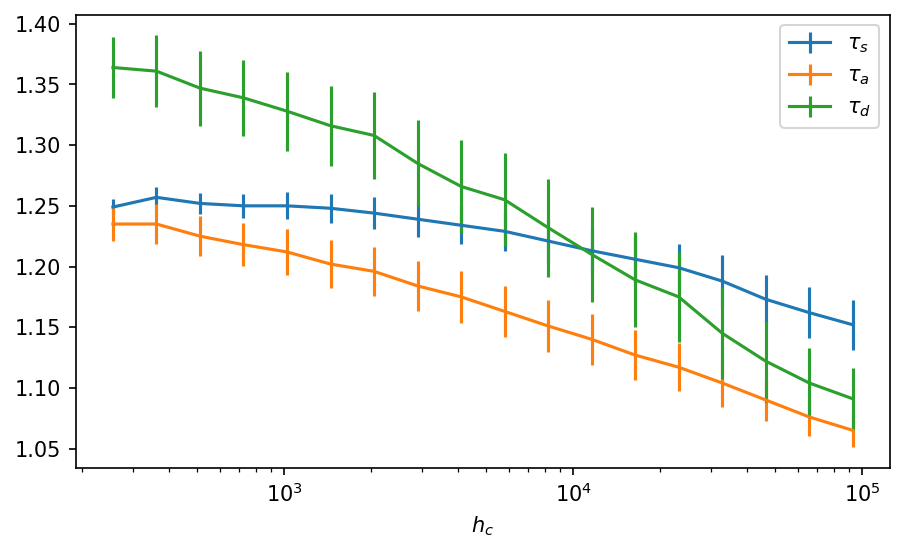

In [21]:
fig, ax1 = plt.subplots(1,1,figsize=(7, 4), dpi=150, frameon=True)
ax1.errorbar(heightRange, tau_s, yerr=tau_s_err, label=r"$\tau_s$")
ax1.errorbar(heightRange, tau_a, yerr=tau_a_err, label=r"$\tau_a$")
ax1.errorbar(heightRange, tau_d, yerr=tau_d_err, label=r"$\tau_d$")

ax1.set_xscale('log')
ax1.set_xlabel(r'$h_c$')
ax1.legend()
plt.savefig("Plots_fortran/expon_tau.png", dpi=240, bbox_inches='tight')

### $\sigma$ vs. $h_c$

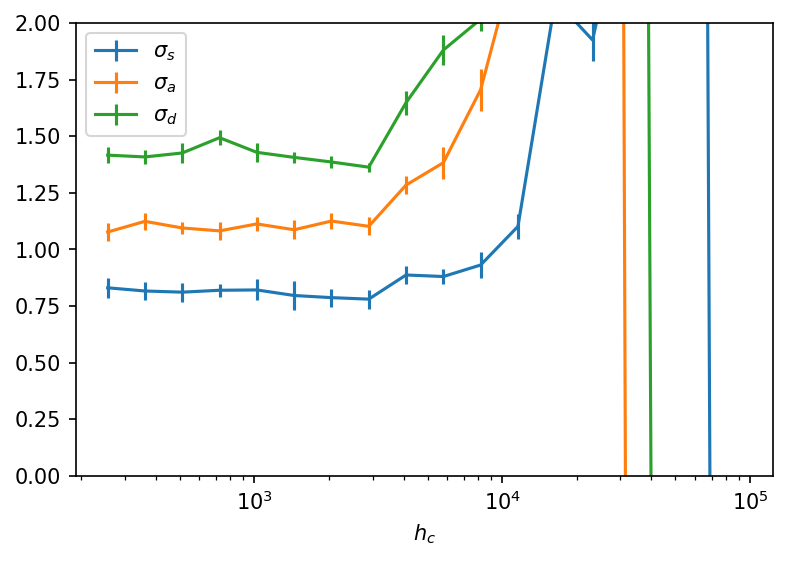

In [22]:
fig, ax1 = plt.subplots(1,1,figsize=(6, 4), dpi=150, frameon=True)

ax1.errorbar(heightRange, sigma_s, yerr=sigma_s_err, label=r"$\sigma_s$")
ax1.errorbar(heightRange, sigma_a, yerr=sigma_a_err, label=r"$\sigma_a$")
ax1.errorbar(heightRange, sigma_d, yerr=sigma_d_err, label=r"$\sigma_d$")

ax1.set_xscale('log')
ax1.set_xlabel(r'$h_c$')
ax1.set_ylim([0,2])
ax1.legend()
plt.savefig("Plots_fortran/expon_sigma.png", dpi=240, bbox_inches='tight')

### $\gamma$ vs. $h_c$

In [23]:
fig, ax1 = plt.subplots(1,1,figsize=(7, 4), dpi=150, frameon=True)

ax1.plot(heightRange, gamma_s, '.-', label=r"$\gamma_s$")
ax1.plot(heightRange, gamma_a, '.-', label=r"$\gamma_a$")
ax1.plot(heightRange, gamma_d, '.-', label=r"$\gamma_d$")

ax1.set_xscale('log')
ax1.set_xlabel(r'$h_c$')
ax1.legend()
plt.savefig("Plots_fortran/expon_gamma.png", dpi=240, bbox_inches='tight')

### compare $\gamma$ and $1/\sigma$

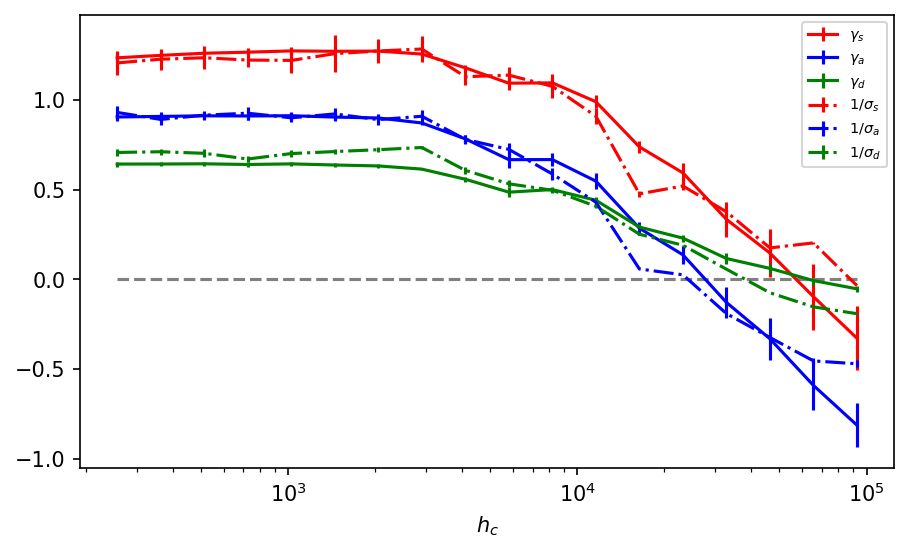

In [28]:
fig, ax1 = plt.subplots(1,1,figsize=(7, 4), dpi=150, frameon=True)

ax1.errorbar(heightRange, np.asarray(gamma_s), yerr=gamma_s_err, color='r', label=r"$\gamma_s$")
ax1.errorbar(heightRange, np.asarray(gamma_a), yerr=gamma_a_err, color='b', label=r"$\gamma_a$")
ax1.errorbar(heightRange, np.asarray(gamma_d), yerr=gamma_d_err, color='g', label=r"$\gamma_d$")

ax1.errorbar(heightRange, 1/np.asarray(sigma_s), yerr=1/np.asarray(sigma_s)**2*np.asarray(sigma_s_err), color='r', linestyle='-.', label=r"$1/\sigma_s$")
ax1.errorbar(heightRange, 1/np.asarray(sigma_a), yerr=1/np.asarray(sigma_a)**2*np.asarray(sigma_a_err), color='b', linestyle='-.', label=r"$1/\sigma_a$")
ax1.errorbar(heightRange, 1/np.asarray(sigma_d), yerr=1/np.asarray(sigma_d)**2*np.asarray(sigma_d_err), color='g', linestyle='-.', label=r"$1/\sigma_d$")

ax1.plot(heightRange, heightRange * 0, '--', color='grey')
ax1.set_xscale('log')
ax1.set_xlabel(r'$h_c$')
ax1.legend(fontsize=7)
plt.savefig("Plots_fortran/expon_compare.png", dpi=240, bbox_inches='tight')

### $\nu$ vs. $h_c$

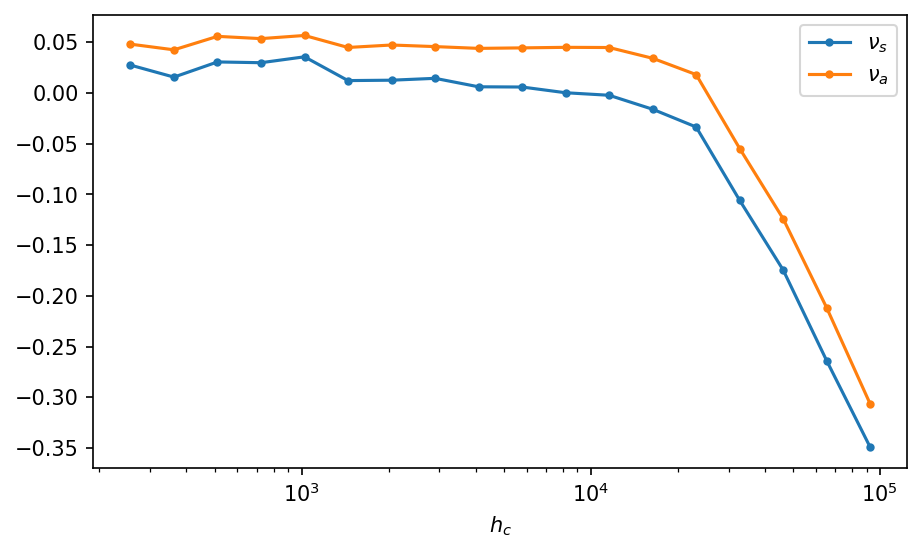

In [37]:
fig, ax1 = plt.subplots(1,1,figsize=(7, 4), dpi=150, frameon=True)

ax1.plot(heightRange, nu_s, '.-', label=r"$\nu_s$")
ax1.plot(heightRange, nu_a, '.-', label=r"$\nu_a$")

ax1.set_xscale('log')
ax1.set_xlabel(r'$h_c$')
ax1.legend()
plt.savefig("Plots_fortran/expon_nu.png", dpi=240, bbox_inches='tight')

### $1 / \sigma \nu z$ vs $hc$ 

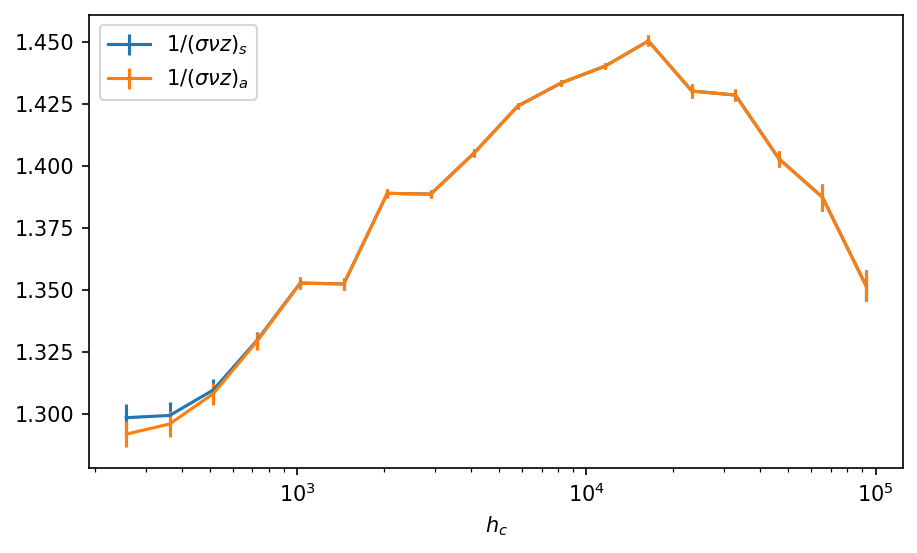

In [56]:
fig, ax1 = plt.subplots(1,1,figsize=(7, 4), dpi=150, frameon=True)

ax1.errorbar(heightRange, sigma_nu_z_s, yerr=sigma_nu_z_s_err, label=r"$1 / (\sigma \nu z)_s$")
ax1.errorbar(heightRange, sigma_nu_z_a, yerr=sigma_nu_z_a_err, label=r"$1 / (\sigma \nu z)_a$")

ax1.set_xscale('log')
ax1.set_xlabel(r'$h_c$')
# ax1.set_ylim([0,2])
ax1.legend()
plt.savefig("Plots_fortran/expon_sigma_nu_z.png", dpi=240, bbox_inches='tight')

$$ \frac{1}{\sigma\nu z} = \frac{\tau_D - 1}{\tau - 1 } $$

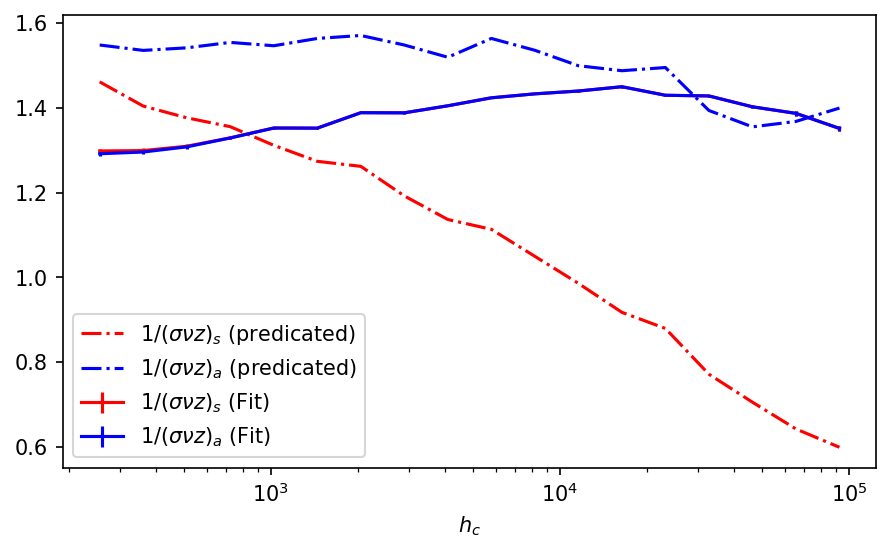

In [38]:
fig, ax1 = plt.subplots(1,1,figsize=(7, 4), dpi=150, frameon=True)

ax1.errorbar(heightRange, sigma_nu_z_s, yerr=sigma_nu_z_s_err, color='r', label=r"$1 / (\sigma \nu z)_s$ (Fit)")
ax1.errorbar(heightRange, sigma_nu_z_a, yerr=sigma_nu_z_a_err, color='b', label=r"$1 / (\sigma \nu z)_a$ (Fit)")

ax1.plot(heightRange, (np.asarray(tau_d)-1) / (np.asarray(tau_s)-1), color='r', linestyle='-.', label=r"$1 / (\sigma \nu z)_s$ (predicated)")
ax1.plot(heightRange, (np.asarray(tau_d)-1) / (np.asarray(tau_a)-1), color='b', linestyle='-.', label=r"$1 / (\sigma \nu z)_a$ (predicated)")

ax1.set_xscale('log')
ax1.set_xlabel(r'$h_c$')
# ax1.set_ylim([0,2])
ax1.legend()
# plt.savefig("Plots_fortran/expon_sigma_nu_z.png", dpi=240, bbox_inches='tight')

## Data Collapse in $n(u)$

In [47]:
for h_i, hc in enumerate(heightRange): 
    indexRange = []
    for j in range(len(fixed_SetRange[0,:])): 
        if fixed_SetRange[0,j] == hc:
            filename = "Histo_fortran/sp_hist" + str(j+1000) + "_s.txt"
            if path.exists(filename):
                indexRange += [j+1000] 

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,4), dpi=120, frameon=True)
    seedRange = [indexRange[8], indexRange[12], indexRange[16]]
    cRange = ['r','g','b', 'y']
    print(hc, end=' ')
    
    for seed_i, seed0 in enumerate(seedRange): 

        ## size 
        x,y,params = plotSizes(seed0, filetype='s');  
        x_re = x * params[2]**(1/sigma_s[h_i])
        y_re = y * params[2]**(-tau_s[h_i]/sigma_s[h_i])
        ax1.plot(x_re, y_re, '.-', color=cRange[seed_i], label = r"$\lambda=$"+str(round(params[2],6)))

        ## area
        x,y,params = plotSizes(seed0, filetype='a');  
        x_re = (x * params[2]**(1 / sigma_a[h_i]))
        y_re = y * ( params[2]**( -tau_a[h_i]/sigma_a[h_i]) )
        ax3.plot(x_re, y_re, '.-', color=cRange[seed_i], label = r"$\lambda=$"+str(round(params[2],6)))

        ## duration
        x,y,params = plotSizes(seed0, filetype='d');  
        x_re = (x * params[2]**(1 / sigma_d[h_i]))
        y_re = y * ( params[2]**( -tau_d[h_i]/sigma_d[h_i]) )
        ax2.plot(x_re, y_re, '.-', color=cRange[seed_i], label = r"$\lambda=$"+str(round(params[2],6)))

    # -- Decoration --
    ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
    ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
    ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax2.set_xscale('log'); ax2.set_yscale('log')
    ax3.set_xscale('log'); ax3.set_yscale('log')
    ax1.legend(loc=1, fontsize=7)
    ax2.legend(loc=1, fontsize=7)
    ax3.legend(loc=1, fontsize=7)
    ax2.set_title(r"$h_c=$"+str(params[3]))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("Plots_fortran/hc"+str(hc)+"_dataCollapse.png", dpi=240, bbox_inches='tight')
    plt.close()


256.0 362.0 512.0 724.0 1024.0 1448.0 2048.0 2896.0 4096.0 5793.0 8192.0 11585.0 16384.0 23170.0 32768.0 46341.0 65536.0 92682.0 

## 2D Plot of No. of Avalanches recorded in 7 days

### The numbers

In [49]:
no_of_sizes = [[ 1000 , 369833 ],
[ 1001 , 349401 ],
[ 1002 , 352027 ],
[ 1003 , 359770 ],
[ 1004 , 388043 ],
[ 1005 , 383525 ],
[ 1006 , 437627 ],
[ 1007 , 441062 ],
[ 1008 , 469520 ],
[ 1009 , 549875 ],
[ 1010 , 673194 ],
[ 1011 , 891287 ],
[ 1012 , 864955 ],
[ 1013 , 1095400 ],
[ 1014 , 1383250 ],
[ 1015 , 1738003 ],
[ 1016 , 2157389 ],
[ 1017 , 2853148 ],
[ 1018 , 3272800 ],
[ 1019 , 3880899 ],
[ 1020 , 291343 ],
[ 1021 , 268620 ],
[ 1022 , 271244 ],
[ 1023 , 276420 ],
[ 1024 , 299185 ],
[ 1025 , 299688 ],
[ 1026 , 318184 ],
[ 1027 , 357239 ],
[ 1028 , 389538 ],
[ 1029 , 457141 ],
[ 1030 , 1295005 ],
[ 1031 , 1550192 ],
[ 1032 , 953901 ],
[ 1033 , 1186771 ],
[ 1034 , 1521442 ],
[ 1035 , 1880956 ],
[ 1036 , 4169812 ],
[ 1037 , 2862688 ],
[ 1038 , 3435173 ],
[ 1039 , 5000000 ],
[ 1040 , 303431 ],
[ 1041 , 298397 ],
[ 1042 , 315790 ],
[ 1043 , 315923 ],
[ 1044 , 326125 ],
[ 1045 , 342170 ],
[ 1046 , 350015 ],
[ 1047 , 396570 ],
[ 1048 , 967929 ],
[ 1049 , 509827 ],
[ 1050 , 608153 ],
[ 1051 , 1612135 ],
[ 1052 , 1805724 ],
[ 1053 , 2314474 ],
[ 1054 , 2796212 ],
[ 1055 , 3388368 ],
[ 1056 , 3985908 ],
[ 1057 , 4723116 ],
[ 1058 , 5000000 ],
[ 1059 , 5000000 ],
[ 1060 , 659510 ],
[ 1061 , 700173 ],
[ 1062 , 695514 ],
[ 1063 , 698000 ],
[ 1064 , 338100 ],
[ 1065 , 747449 ],
[ 1066 , 369719 ],
[ 1067 , 852664 ],
[ 1068 , 912388 ],
[ 1069 , 528943 ],
[ 1070 , 1241554 ],
[ 1071 , 780278 ],
[ 1072 , 1821503 ],
[ 1073 , 2199973 ],
[ 1074 , 2759599 ],
[ 1075 , 3300775 ],
[ 1076 , 3907870 ],
[ 1077 , 4745193 ],
[ 1078 , 3497629 ],
[ 1079 , 4051953 ],
[ 1080 , 702399 ],
[ 1081 , 667659 ],
[ 1082 , 690307 ],
[ 1083 , 686224 ],
[ 1084 , 748757 ],
[ 1085 , 367134 ],
[ 1086 , 381079 ],
[ 1087 , 854049 ],
[ 1088 , 935297 ],
[ 1089 , 1126240 ],
[ 1090 , 1232929 ],
[ 1091 , 820307 ],
[ 1092 , 1852605 ],
[ 1093 , 1102665 ],
[ 1094 , 2703138 ],
[ 1095 , 3366873 ],
[ 1096 , 4092314 ],
[ 1097 , 2877135 ],
[ 1098 , 5000000 ],
[ 1099 , 3503845 ],
[ 1100 , 695122 ],
[ 1101 , 707993 ],
[ 1102 , 700763 ],
[ 1103 , 701370 ],
[ 1104 , 704234 ],
[ 1105 , 727394 ],
[ 1106 , 768832 ],
[ 1107 , 842001 ],
[ 1108 , 952371 ],
[ 1109 , 1053240 ],
[ 1110 , 1265698 ],
[ 1111 , 1498309 ],
[ 1112 , 1862950 ],
[ 1113 , 2200013 ],
[ 1114 , 2694124 ],
[ 1115 , 3304279 ],
[ 1116 , 3855762 ],
[ 1117 , 4720805 ],
[ 1118 , 5000000 ],
[ 1119 , 5000000 ],
[ 1120 , 710711 ],
[ 1121 , 720822 ],
[ 1122 , 688484 ],
[ 1123 , 279936 ],
[ 1124 , 282749 ],
[ 1125 , 298129 ],
[ 1126 , 315801 ],
[ 1127 , 751398 ],
[ 1128 , 820876 ],
[ 1129 , 462863 ],
[ 1130 , 1186961 ],
[ 1131 , 1360548 ],
[ 1132 , 1617063 ],
[ 1133 , 2110063 ],
[ 1134 , 2756151 ],
[ 1135 , 1855462 ],
[ 1136 , 2238622 ],
[ 1137 , 2744072 ],
[ 1138 , 2719352 ],
[ 1139 , 3538671 ],
[ 1140 , 315703 ],
[ 1141 , 680617 ],
[ 1142 , 705306 ],
[ 1143 , 720440 ],
[ 1144 , 724279 ],
[ 1145 , 732214 ],
[ 1146 , 798232 ],
[ 1147 , 846060 ],
[ 1148 , 910863 ],
[ 1149 , 1107178 ],
[ 1150 , 1256983 ],
[ 1151 , 1449415 ],
[ 1152 , 1791161 ],
[ 1153 , 2130125 ],
[ 1154 , 2601613 ],
[ 1155 , 3001178 ],
[ 1156 , 3694448 ],
[ 1157 , 4331738 ],
[ 1158 , 5000000 ],
[ 1159 , 5000000 ],
[ 1160 , 678331 ],
[ 1161 , 294912 ],
[ 1162 , 272808 ],
[ 1163 , 270483 ],
[ 1164 , 305031 ],
[ 1165 , 320327 ],
[ 1166 , 310772 ],
[ 1167 , 334444 ],
[ 1168 , 391069 ],
[ 1169 , 459455 ],
[ 1170 , 551237 ],
[ 1171 , 819543 ],
[ 1172 , 1156048 ],
[ 1173 , 1117162 ],
[ 1174 , 1436273 ],
[ 1175 , 1562169 ],
[ 1176 , 3728578 ],
[ 1177 , 4067067 ],
[ 1178 , 4721348 ],
[ 1179 , 5000000 ],
[ 1180 , 654046 ],
[ 1181 , 648652 ],
[ 1182 , 648729 ],
[ 1183 , 666136 ],
[ 1184 , 674149 ],
[ 1185 , 284585 ],
[ 1186 , 735854 ],
[ 1187 , 335898 ],
[ 1188 , 886585 ],
[ 1189 , 1001263 ],
[ 1190 , 538605 ],
[ 1191 , 713552 ],
[ 1192 , 786121 ],
[ 1193 , 900402 ],
[ 1194 , 952990 ],
[ 1195 , 1252169 ],
[ 1196 , 1556032 ],
[ 1197 , 1892241 ],
[ 1198 , 2268004 ],
[ 1199 , 4779122 ],
[ 1200 , 258284 ],
[ 1201 , 260614 ],
[ 1202 , 656058 ],
[ 1203 , 663003 ],
[ 1204 , 723235 ],
[ 1205 , 701211 ],
[ 1206 , 722861 ],
[ 1207 , 329398 ],
[ 1208 , 375403 ],
[ 1209 , 987262 ],
[ 1210 , 1275887 ],
[ 1211 , 1409916 ],
[ 1212 , 1681081 ],
[ 1213 , 1964054 ],
[ 1214 , 2238441 ],
[ 1215 , 2746826 ],
[ 1216 , 1391806 ],
[ 1217 , 3602040 ],
[ 1218 , 4300478 ],
[ 1219 , 4714694 ],
[ 1220 , 638279 ],
[ 1221 , 609922 ],
[ 1222 , 648148 ],
[ 1223 , 624009 ],
[ 1224 , 685359 ],
[ 1225 , 642826 ],
[ 1226 , 697618 ],
[ 1227 , 746698 ],
[ 1228 , 830269 ],
[ 1229 , 428820 ],
[ 1230 , 1205298 ],
[ 1231 , 1341603 ],
[ 1232 , 1623888 ],
[ 1233 , 1676651 ],
[ 1234 , 2178257 ],
[ 1235 , 2479936 ],
[ 1236 , 2925480 ],
[ 1237 , 3489935 ],
[ 1238 , 4197588 ],
[ 1239 , 4733037 ],
[ 1240 , 661962 ],
[ 1241 , 679271 ],
[ 1242 , 669741 ],
[ 1243 , 640581 ],
[ 1244 , 692346 ],
[ 1245 , 680892 ],
[ 1246 , 748035 ],
[ 1247 , 353457 ],
[ 1248 , 372654 ],
[ 1249 , 434076 ],
[ 1250 , 488027 ],
[ 1251 , 525106 ],
[ 1252 , 555876 ],
[ 1253 , 622080 ],
[ 1254 , 992351 ],
[ 1255 , 1206558 ],
[ 1256 , 1354235 ],
[ 1257 , 1108028 ],
[ 1258 , 1392190 ],
[ 1259 , 2584531 ],
[ 1260 , 177912 ],
[ 1261 , 326738 ],
[ 1262 , 307749 ],
[ 1263 , 327220 ],
[ 1264 , 185098 ],
[ 1265 , 373846 ],
[ 1266 , 379452 ],
[ 1267 , 368389 ],
[ 1268 , 255620 ],
[ 1269 , 284093 ],
[ 1270 , 601843 ],
[ 1271 , 336372 ],
[ 1272 , 599233 ],
[ 1273 , 687515 ],
[ 1274 , 825893 ],
[ 1275 , 757018 ],
[ 1276 , 748753 ],
[ 1277 , 1617825 ],
[ 1278 , 1599242 ],
[ 1279 , 2052247 ],
[ 1280 , 320588 ],
[ 1281 , 232166 ],
[ 1282 , 294246 ],
[ 1283 , 289591 ],
[ 1284 , 246479 ],
[ 1285 , 309302 ],
[ 1286 , 350681 ],
[ 1287 , 354280 ],
[ 1288 , 384664 ],
[ 1289 , 421131 ],
[ 1290 , 460165 ],
[ 1291 , 432867 ],
[ 1292 , 460838 ],
[ 1293 , 578291 ],
[ 1294 , 572321 ],
[ 1295 , 708160 ],
[ 1296 , 1111654 ],
[ 1297 , 992521 ],
[ 1298 , 1662928 ],
[ 1299 , 1802749 ],
[ 1300 , 280595 ],
[ 1301 , 152165 ],
[ 1302 , 285296 ],
[ 1303 , 156994 ],
[ 1304 , 288443 ],
[ 1305 , 295759 ],
[ 1306 , 341268 ],
[ 1307 , 368423 ],
[ 1308 , 307855 ],
[ 1309 , 322019 ],
[ 1310 , 436587 ],
[ 1311 , 399827 ],
[ 1312 , 406726 ],
[ 1313 , 511974 ],
[ 1314 , 618819 ],
[ 1315 , 767566 ],
[ 1316 , 1105265 ],
[ 1317 , 819345 ],
[ 1318 , 935478 ],
[ 1319 , 1569666 ],
[ 1320 , 268886 ],
[ 1321 , 269637 ],
[ 1322 , 217413 ],
[ 1323 , 276191 ],
[ 1324 , 155895 ],
[ 1325 , 160844 ],
[ 1326 , 248829 ],
[ 1327 , 323434 ],
[ 1328 , 322533 ],
[ 1329 , 386000 ],
[ 1330 , 328803 ],
[ 1331 , 361684 ],
[ 1332 , 367788 ],
[ 1333 , 423304 ],
[ 1334 , 567561 ],
[ 1335 , 733559 ],
[ 1336 , 932941 ],
[ 1337 , 1130961 ],
[ 1338 , 1247702 ],
[ 1339 , 1268766 ],
[ 1340 , 262636 ],
[ 1341 , 260313 ],
[ 1342 , 262691 ],
[ 1343 , 251165 ],
[ 1344 , 269602 ],
[ 1345 , 279270 ],
[ 1346 , 272777 ],
[ 1347 , 293030 ],
[ 1348 , 296748 ],
[ 1349 , 277379 ],
[ 1350 , 293832 ],
[ 1351 , 300381 ],
[ 1352 , 327404 ],
[ 1353 , 399169 ],
[ 1354 , 519957 ],
[ 1355 , 526037 ],
[ 1356 , 706525 ],
[ 1357 , 812699 ],
[ 1358 , 952924 ],
[ 1359 , 791765 ]]
no_of_areas = [[ 1000 , 371582 ],
[ 1001 , 347841 ],
[ 1002 , 350495 ],
[ 1003 , 361187 ],
[ 1004 , 387638 ],
[ 1005 , 382822 ],
[ 1006 , 435736 ],
[ 1007 , 441600 ],
[ 1008 , 470497 ],
[ 1009 , 549808 ],
[ 1010 , 672546 ],
[ 1011 , 891065 ],
[ 1012 , 863819 ],
[ 1013 , 1095898 ],
[ 1014 , 1381348 ],
[ 1015 , 1738354 ],
[ 1016 , 2160271 ],
[ 1017 , 2853842 ],
[ 1018 , 3272213 ],
[ 1019 , 3882108 ],
[ 1020 , 290248 ],
[ 1021 , 269302 ],
[ 1022 , 272072 ],
[ 1023 , 277441 ],
[ 1024 , 298256 ],
[ 1025 , 298665 ],
[ 1026 , 317520 ],
[ 1027 , 354869 ],
[ 1028 , 390316 ],
[ 1029 , 456565 ],
[ 1030 , 1293888 ],
[ 1031 , 1548457 ],
[ 1032 , 953723 ],
[ 1033 , 1187845 ],
[ 1034 , 1520211 ],
[ 1035 , 1878429 ],
[ 1036 , 4168381 ],
[ 1037 , 2861318 ],
[ 1038 , 3433353 ],
[ 1039 , 5000000 ],
[ 1040 , 302400 ],
[ 1041 , 297190 ],
[ 1042 , 315140 ],
[ 1043 , 317889 ],
[ 1044 , 325733 ],
[ 1045 , 342008 ],
[ 1046 , 350083 ],
[ 1047 , 395075 ],
[ 1048 , 968868 ],
[ 1049 , 507603 ],
[ 1050 , 607431 ],
[ 1051 , 1610557 ],
[ 1052 , 1807296 ],
[ 1053 , 2316332 ],
[ 1054 , 2796344 ],
[ 1055 , 3388442 ],
[ 1056 , 3986348 ],
[ 1057 , 4722877 ],
[ 1058 , 5000000 ],
[ 1059 , 5000000 ],
[ 1060 , 658569 ],
[ 1061 , 700471 ],
[ 1062 , 695637 ],
[ 1063 , 698142 ],
[ 1064 , 337798 ],
[ 1065 , 748571 ],
[ 1066 , 369926 ],
[ 1067 , 853144 ],
[ 1068 , 913748 ],
[ 1069 , 526899 ],
[ 1070 , 1239605 ],
[ 1071 , 778203 ],
[ 1072 , 1821879 ],
[ 1073 , 2200913 ],
[ 1074 , 2759746 ],
[ 1075 , 3300217 ],
[ 1076 , 3908052 ],
[ 1077 , 4744904 ],
[ 1078 , 3500034 ],
[ 1079 , 4052148 ],
[ 1080 , 702371 ],
[ 1081 , 669037 ],
[ 1082 , 689615 ],
[ 1083 , 685436 ],
[ 1084 , 749627 ],
[ 1085 , 367287 ],
[ 1086 , 381283 ],
[ 1087 , 853978 ],
[ 1088 , 936398 ],
[ 1089 , 1125535 ],
[ 1090 , 1232440 ],
[ 1091 , 820967 ],
[ 1092 , 1851950 ],
[ 1093 , 1102258 ],
[ 1094 , 2703009 ],
[ 1095 , 3366745 ],
[ 1096 , 4090165 ],
[ 1097 , 2879293 ],
[ 1098 , 5000000 ],
[ 1099 , 3503917 ],
[ 1100 , 694221 ],
[ 1101 , 710006 ],
[ 1102 , 702406 ],
[ 1103 , 702927 ],
[ 1104 , 705766 ],
[ 1105 , 726820 ],
[ 1106 , 769149 ],
[ 1107 , 840949 ],
[ 1108 , 950561 ],
[ 1109 , 1052322 ],
[ 1110 , 1264760 ],
[ 1111 , 1498110 ],
[ 1112 , 1863586 ],
[ 1113 , 2199983 ],
[ 1114 , 2694051 ],
[ 1115 , 3306882 ],
[ 1116 , 3855885 ],
[ 1117 , 4721189 ],
[ 1118 , 5000000 ],
[ 1119 , 5000000 ],
[ 1120 , 712091 ],
[ 1121 , 719968 ],
[ 1122 , 686790 ],
[ 1123 , 279870 ],
[ 1124 , 282673 ],
[ 1125 , 298408 ],
[ 1126 , 316356 ],
[ 1127 , 752489 ],
[ 1128 , 820252 ],
[ 1129 , 463137 ],
[ 1130 , 1188624 ],
[ 1131 , 1362009 ],
[ 1132 , 1617586 ],
[ 1133 , 2109767 ],
[ 1134 , 2757174 ],
[ 1135 , 1856260 ],
[ 1136 , 2237677 ],
[ 1137 , 2743119 ],
[ 1138 , 2716336 ],
[ 1139 , 3538671 ],
[ 1140 , 316363 ],
[ 1141 , 680814 ],
[ 1142 , 706057 ],
[ 1143 , 721491 ],
[ 1144 , 725221 ],
[ 1145 , 730658 ],
[ 1146 , 797835 ],
[ 1147 , 843714 ],
[ 1148 , 911633 ],
[ 1149 , 1105887 ],
[ 1150 , 1256355 ],
[ 1151 , 1448492 ],
[ 1152 , 1792738 ],
[ 1153 , 2130791 ],
[ 1154 , 2603877 ],
[ 1155 , 3002532 ],
[ 1156 , 3695242 ],
[ 1157 , 4330970 ],
[ 1158 , 5000000 ],
[ 1159 , 5000000 ],
[ 1160 , 677873 ],
[ 1161 , 294757 ],
[ 1162 , 272147 ],
[ 1163 , 272317 ],
[ 1164 , 304962 ],
[ 1165 , 320628 ],
[ 1166 , 310741 ],
[ 1167 , 334713 ],
[ 1168 , 392256 ],
[ 1169 , 458886 ],
[ 1170 , 551444 ],
[ 1171 , 820099 ],
[ 1172 , 1155519 ],
[ 1173 , 1117935 ],
[ 1174 , 1437706 ],
[ 1175 , 1564383 ],
[ 1176 , 3727477 ],
[ 1177 , 4068242 ],
[ 1178 , 4721428 ],
[ 1179 , 5000000 ],
[ 1180 , 652381 ],
[ 1181 , 649391 ],
[ 1182 , 647073 ],
[ 1183 , 664758 ],
[ 1184 , 672752 ],
[ 1185 , 283782 ],
[ 1186 , 735387 ],
[ 1187 , 335893 ],
[ 1188 , 887998 ],
[ 1189 , 1003709 ],
[ 1190 , 538309 ],
[ 1191 , 711767 ],
[ 1192 , 785024 ],
[ 1193 , 900110 ],
[ 1194 , 952398 ],
[ 1195 , 1252256 ],
[ 1196 , 1557141 ],
[ 1197 , 1892455 ],
[ 1198 , 2268005 ],
[ 1199 , 4779122 ],
[ 1200 , 259359 ],
[ 1201 , 259296 ],
[ 1202 , 654028 ],
[ 1203 , 663575 ],
[ 1204 , 722577 ],
[ 1205 , 702226 ],
[ 1206 , 721607 ],
[ 1207 , 329049 ],
[ 1208 , 375657 ],
[ 1209 , 986027 ],
[ 1210 , 1277708 ],
[ 1211 , 1409797 ],
[ 1212 , 1681429 ],
[ 1213 , 1963975 ],
[ 1214 , 2238425 ],
[ 1215 , 2746709 ],
[ 1216 , 1392357 ],
[ 1217 , 3602187 ],
[ 1218 , 4300478 ],
[ 1219 , 4714694 ],
[ 1220 , 637853 ],
[ 1221 , 611265 ],
[ 1222 , 648003 ],
[ 1223 , 625588 ],
[ 1224 , 685823 ],
[ 1225 , 642042 ],
[ 1226 , 697637 ],
[ 1227 , 747266 ],
[ 1228 , 829031 ],
[ 1229 , 429206 ],
[ 1230 , 1204932 ],
[ 1231 , 1341696 ],
[ 1232 , 1623989 ],
[ 1233 , 1674189 ],
[ 1234 , 2178353 ],
[ 1235 , 2480708 ],
[ 1236 , 2923413 ],
[ 1237 , 3489955 ],
[ 1238 , 4197588 ],
[ 1239 , 4733037 ],
[ 1240 , 661540 ],
[ 1241 , 679155 ],
[ 1242 , 669423 ],
[ 1243 , 639585 ],
[ 1244 , 692346 ],
[ 1245 , 680479 ],
[ 1246 , 746112 ],
[ 1247 , 352911 ],
[ 1248 , 372226 ],
[ 1249 , 431680 ],
[ 1250 , 487856 ],
[ 1251 , 523563 ],
[ 1252 , 557481 ],
[ 1253 , 622128 ],
[ 1254 , 991966 ],
[ 1255 , 1207551 ],
[ 1256 , 1351434 ],
[ 1257 , 1108028 ],
[ 1258 , 1392190 ],
[ 1259 , 2584531 ],
[ 1260 , 176753 ],
[ 1261 , 326227 ],
[ 1262 , 309287 ],
[ 1263 , 326626 ],
[ 1264 , 184032 ],
[ 1265 , 374088 ],
[ 1266 , 379521 ],
[ 1267 , 367999 ],
[ 1268 , 255347 ],
[ 1269 , 283761 ],
[ 1270 , 602655 ],
[ 1271 , 337121 ],
[ 1272 , 600570 ],
[ 1273 , 687477 ],
[ 1274 , 827341 ],
[ 1275 , 757421 ],
[ 1276 , 745813 ],
[ 1277 , 1617825 ],
[ 1278 , 1599242 ],
[ 1279 , 2052247 ],
[ 1280 , 319665 ],
[ 1281 , 231940 ],
[ 1282 , 295324 ],
[ 1283 , 288086 ],
[ 1284 , 246467 ],
[ 1285 , 307989 ],
[ 1286 , 349998 ],
[ 1287 , 355743 ],
[ 1288 , 383834 ],
[ 1289 , 422548 ],
[ 1290 , 460707 ],
[ 1291 , 431400 ],
[ 1292 , 460799 ],
[ 1293 , 580121 ],
[ 1294 , 573081 ],
[ 1295 , 708425 ],
[ 1296 , 1111691 ],
[ 1297 , 992521 ],
[ 1298 , 1662928 ],
[ 1299 , 1802749 ],
[ 1300 , 281229 ],
[ 1301 , 152678 ],
[ 1302 , 285990 ],
[ 1303 , 155159 ],
[ 1304 , 289065 ],
[ 1305 , 296419 ],
[ 1306 , 340208 ],
[ 1307 , 367459 ],
[ 1308 , 307823 ],
[ 1309 , 323856 ],
[ 1310 , 436208 ],
[ 1311 , 400285 ],
[ 1312 , 408593 ],
[ 1313 , 513268 ],
[ 1314 , 619491 ],
[ 1315 , 767757 ],
[ 1316 , 1105293 ],
[ 1317 , 819345 ],
[ 1318 , 935478 ],
[ 1319 , 1569666 ],
[ 1320 , 269096 ],
[ 1321 , 269806 ],
[ 1322 , 216630 ],
[ 1323 , 274124 ],
[ 1324 , 153945 ],
[ 1325 , 158900 ],
[ 1326 , 248278 ],
[ 1327 , 323826 ],
[ 1328 , 322308 ],
[ 1329 , 385715 ],
[ 1330 , 329319 ],
[ 1331 , 361577 ],
[ 1332 , 366813 ],
[ 1333 , 421687 ],
[ 1334 , 568086 ],
[ 1335 , 733695 ],
[ 1336 , 932941 ],
[ 1337 , 1130961 ],
[ 1338 , 1247702 ],
[ 1339 , 1268766 ],
[ 1340 , 262639 ],
[ 1341 , 260260 ],
[ 1342 , 262646 ],
[ 1343 , 250807 ],
[ 1344 , 269571 ],
[ 1345 , 279261 ],
[ 1346 , 272466 ],
[ 1347 , 294982 ],
[ 1348 , 298206 ],
[ 1349 , 275522 ],
[ 1350 , 293826 ],
[ 1351 , 302218 ],
[ 1352 , 328680 ],
[ 1353 , 397495 ],
[ 1354 , 520345 ],
[ 1355 , 526082 ],
[ 1356 , 706525 ],
[ 1357 , 812699 ],
[ 1358 , 952924 ],
[ 1359 , 791765 ]]
no_of_lifetimes = [[ 1000 , 370683 ],
[ 1001 , 349834 ],
[ 1002 , 349866 ],
[ 1003 , 358969 ],
[ 1004 , 389009 ],
[ 1005 , 383520 ],
[ 1006 , 437670 ],
[ 1007 , 441345 ],
[ 1008 , 470404 ],
[ 1009 , 550998 ],
[ 1010 , 673518 ],
[ 1011 , 890579 ],
[ 1012 , 864081 ],
[ 1013 , 1094717 ],
[ 1014 , 1381074 ],
[ 1015 , 1738082 ],
[ 1016 , 2158804 ],
[ 1017 , 2854737 ],
[ 1018 , 3271991 ],
[ 1019 , 3881311 ],
[ 1020 , 290204 ],
[ 1021 , 269527 ],
[ 1022 , 272557 ],
[ 1023 , 275585 ],
[ 1024 , 299361 ],
[ 1025 , 299775 ],
[ 1026 , 318215 ],
[ 1027 , 354640 ],
[ 1028 , 388885 ],
[ 1029 , 457376 ],
[ 1030 , 1293650 ],
[ 1031 , 1549267 ],
[ 1032 , 952148 ],
[ 1033 , 1187425 ],
[ 1034 , 1519965 ],
[ 1035 , 1880106 ],
[ 1036 , 4169435 ],
[ 1037 , 2861294 ],
[ 1038 , 3433420 ],
[ 1039 , 5000000 ],
[ 1040 , 301735 ],
[ 1041 , 298591 ],
[ 1042 , 316325 ],
[ 1043 , 316483 ],
[ 1044 , 325489 ],
[ 1045 , 340961 ],
[ 1046 , 350120 ],
[ 1047 , 395477 ],
[ 1048 , 967108 ],
[ 1049 , 507446 ],
[ 1050 , 607342 ],
[ 1051 , 1610543 ],
[ 1052 , 1805843 ],
[ 1053 , 2315262 ],
[ 1054 , 2796295 ],
[ 1055 , 3389631 ],
[ 1056 , 3986504 ],
[ 1057 , 4722708 ],
[ 1058 , 5000000 ],
[ 1059 , 5000000 ],
[ 1060 , 657820 ],
[ 1061 , 699555 ],
[ 1062 , 693955 ],
[ 1063 , 696857 ],
[ 1064 , 336787 ],
[ 1065 , 748333 ],
[ 1066 , 370389 ],
[ 1067 , 852329 ],
[ 1068 , 911795 ],
[ 1069 , 527409 ],
[ 1070 , 1239728 ],
[ 1071 , 779014 ],
[ 1072 , 1820176 ],
[ 1073 , 2198445 ],
[ 1074 , 2756846 ],
[ 1075 , 3302506 ],
[ 1076 , 3907450 ],
[ 1077 , 4743258 ],
[ 1078 , 3498070 ],
[ 1079 , 4052992 ],
[ 1080 , 700348 ],
[ 1081 , 668115 ],
[ 1082 , 688826 ],
[ 1083 , 686630 ],
[ 1084 , 748477 ],
[ 1085 , 368557 ],
[ 1086 , 381363 ],
[ 1087 , 852460 ],
[ 1088 , 936642 ],
[ 1089 , 1124281 ],
[ 1090 , 1230936 ],
[ 1091 , 820117 ],
[ 1092 , 1851121 ],
[ 1093 , 1103301 ],
[ 1094 , 2701100 ],
[ 1095 , 3366278 ],
[ 1096 , 4089968 ],
[ 1097 , 2877748 ],
[ 1098 , 5000000 ],
[ 1099 , 3506212 ],
[ 1100 , 695558 ],
[ 1101 , 707870 ],
[ 1102 , 701880 ],
[ 1103 , 702685 ],
[ 1104 , 705819 ],
[ 1105 , 726738 ],
[ 1106 , 769160 ],
[ 1107 , 842027 ],
[ 1108 , 951983 ],
[ 1109 , 1052242 ],
[ 1110 , 1264261 ],
[ 1111 , 1497487 ],
[ 1112 , 1862213 ],
[ 1113 , 2199917 ],
[ 1114 , 2693177 ],
[ 1115 , 3304522 ],
[ 1116 , 3855863 ],
[ 1117 , 4721127 ],
[ 1118 , 5000000 ],
[ 1119 , 5000000 ],
[ 1120 , 712006 ],
[ 1121 , 720880 ],
[ 1122 , 688554 ],
[ 1123 , 278350 ],
[ 1124 , 284548 ],
[ 1125 , 296585 ],
[ 1126 , 314305 ],
[ 1127 , 751308 ],
[ 1128 , 822246 ],
[ 1129 , 460801 ],
[ 1130 , 1189168 ],
[ 1131 , 1360360 ],
[ 1132 , 1616645 ],
[ 1133 , 2111207 ],
[ 1134 , 2756799 ],
[ 1135 , 1857606 ],
[ 1136 , 2236166 ],
[ 1137 , 2741509 ],
[ 1138 , 2716077 ],
[ 1139 , 3538358 ],
[ 1140 , 315343 ],
[ 1141 , 680438 ],
[ 1142 , 706665 ],
[ 1143 , 721570 ],
[ 1144 , 725461 ],
[ 1145 , 731733 ],
[ 1146 , 797162 ],
[ 1147 , 843442 ],
[ 1148 , 911746 ],
[ 1149 , 1106519 ],
[ 1150 , 1257770 ],
[ 1151 , 1447648 ],
[ 1152 , 1792409 ],
[ 1153 , 2127974 ],
[ 1154 , 2601340 ],
[ 1155 , 3002924 ],
[ 1156 , 3696345 ],
[ 1157 , 4330995 ],
[ 1158 , 5000000 ],
[ 1159 , 5000000 ],
[ 1160 , 678777 ],
[ 1161 , 294265 ],
[ 1162 , 270958 ],
[ 1163 , 271032 ],
[ 1164 , 305976 ],
[ 1165 , 318011 ],
[ 1166 , 309577 ],
[ 1167 , 333954 ],
[ 1168 , 390982 ],
[ 1169 , 458150 ],
[ 1170 , 551102 ],
[ 1171 , 820581 ],
[ 1172 , 1156665 ],
[ 1173 , 1118564 ],
[ 1174 , 1437342 ],
[ 1175 , 1564363 ],
[ 1176 , 3729972 ],
[ 1177 , 4067896 ],
[ 1178 , 4722009 ],
[ 1179 , 5000000 ],
[ 1180 , 653713 ],
[ 1181 , 650530 ],
[ 1182 , 647611 ],
[ 1183 , 665338 ],
[ 1184 , 674174 ],
[ 1185 , 285000 ],
[ 1186 , 734546 ],
[ 1187 , 336046 ],
[ 1188 , 885775 ],
[ 1189 , 1002897 ],
[ 1190 , 537403 ],
[ 1191 , 712867 ],
[ 1192 , 784393 ],
[ 1193 , 900579 ],
[ 1194 , 952091 ],
[ 1195 , 1252511 ],
[ 1196 , 1556112 ],
[ 1197 , 1890442 ],
[ 1198 , 2270315 ],
[ 1199 , 4780506 ],
[ 1200 , 260354 ],
[ 1201 , 260342 ],
[ 1202 , 654410 ],
[ 1203 , 662713 ],
[ 1204 , 724812 ],
[ 1205 , 701622 ],
[ 1206 , 720422 ],
[ 1207 , 328890 ],
[ 1208 , 376680 ],
[ 1209 , 987918 ],
[ 1210 , 1276295 ],
[ 1211 , 1410414 ],
[ 1212 , 1680765 ],
[ 1213 , 1963534 ],
[ 1214 , 2238087 ],
[ 1215 , 2747999 ],
[ 1216 , 1391970 ],
[ 1217 , 3602476 ],
[ 1218 , 4302325 ],
[ 1219 , 4713884 ],
[ 1220 , 637356 ],
[ 1221 , 612000 ],
[ 1222 , 649123 ],
[ 1223 , 626140 ],
[ 1224 , 687179 ],
[ 1225 , 641841 ],
[ 1226 , 697590 ],
[ 1227 , 745904 ],
[ 1228 , 827908 ],
[ 1229 , 427364 ],
[ 1230 , 1204392 ],
[ 1231 , 1341759 ],
[ 1232 , 1622180 ],
[ 1233 , 1675555 ],
[ 1234 , 2178533 ],
[ 1235 , 2480738 ],
[ 1236 , 2924985 ],
[ 1237 , 3489677 ],
[ 1238 , 4195117 ],
[ 1239 , 4733876 ],
[ 1240 , 661105 ],
[ 1241 , 678703 ],
[ 1242 , 670198 ],
[ 1243 , 641166 ],
[ 1244 , 690831 ],
[ 1245 , 679731 ],
[ 1246 , 747167 ],
[ 1247 , 352796 ],
[ 1248 , 371589 ],
[ 1249 , 431505 ],
[ 1250 , 489295 ],
[ 1251 , 525273 ],
[ 1252 , 557805 ],
[ 1253 , 623997 ],
[ 1254 , 991007 ],
[ 1255 , 1206803 ],
[ 1256 , 1351827 ],
[ 1257 , 1108962 ],
[ 1258 , 1391852 ],
[ 1259 , 2583677 ],
[ 1260 , 177464 ],
[ 1261 , 326222 ],
[ 1262 , 309116 ],
[ 1263 , 326531 ],
[ 1264 , 186131 ],
[ 1265 , 372931 ],
[ 1266 , 379263 ],
[ 1267 , 368503 ],
[ 1268 , 254090 ],
[ 1269 , 284001 ],
[ 1270 , 603606 ],
[ 1271 , 334328 ],
[ 1272 , 599719 ],
[ 1273 , 687646 ],
[ 1274 , 826424 ],
[ 1275 , 758247 ],
[ 1276 , 746976 ],
[ 1277 , 1617803 ],
[ 1278 , 1600207 ],
[ 1279 , 2053594 ],
[ 1280 , 319403 ],
[ 1281 , 233881 ],
[ 1282 , 293680 ],
[ 1283 , 288172 ],
[ 1284 , 245256 ],
[ 1285 , 308327 ],
[ 1286 , 351789 ],
[ 1287 , 355384 ],
[ 1288 , 384881 ],
[ 1289 , 420689 ],
[ 1290 , 460721 ],
[ 1291 , 432691 ],
[ 1292 , 460823 ],
[ 1293 , 578792 ],
[ 1294 , 573475 ],
[ 1295 , 707723 ],
[ 1296 , 1112647 ],
[ 1297 , 991849 ],
[ 1298 , 1661922 ],
[ 1299 , 1800570 ],
[ 1300 , 280898 ],
[ 1301 , 150468 ],
[ 1302 , 286700 ],
[ 1303 , 156079 ],
[ 1304 , 289861 ],
[ 1305 , 295807 ],
[ 1306 , 341377 ],
[ 1307 , 367583 ],
[ 1308 , 305734 ],
[ 1309 , 323710 ],
[ 1310 , 435866 ],
[ 1311 , 400879 ],
[ 1312 , 407988 ],
[ 1313 , 512866 ],
[ 1314 , 619003 ],
[ 1315 , 769147 ],
[ 1316 , 1104274 ],
[ 1317 , 818123 ],
[ 1318 , 937826 ],
[ 1319 , 1571654 ],
[ 1320 , 270681 ],
[ 1321 , 271284 ],
[ 1322 , 217384 ],
[ 1323 , 273739 ],
[ 1324 , 155225 ],
[ 1325 , 161055 ],
[ 1326 , 246074 ],
[ 1327 , 323059 ],
[ 1328 , 320895 ],
[ 1329 , 385415 ],
[ 1330 , 329614 ],
[ 1331 , 360306 ],
[ 1332 , 366930 ],
[ 1333 , 421909 ],
[ 1334 , 565618 ],
[ 1335 , 731175 ],
[ 1336 , 934762 ],
[ 1337 , 1130447 ],
[ 1338 , 1248309 ],
[ 1339 , 1266988 ],
[ 1340 , 263728 ],
[ 1341 , 258304 ],
[ 1342 , 261175 ],
[ 1343 , 252790 ],
[ 1344 , 269385 ],
[ 1345 , 277772 ],
[ 1346 , 272643 ],
[ 1347 , 293010 ],
[ 1348 , 296440 ],
[ 1349 , 277594 ],
[ 1350 , 292667 ],
[ 1351 , 301855 ],
[ 1352 , 327876 ],
[ 1353 , 398299 ],
[ 1354 , 521016 ],
[ 1355 , 525858 ],
[ 1356 , 707830 ],
[ 1357 , 811224 ],
[ 1358 , 953274 ],
[ 1359 , 791743 ]]


### Plotting the data

In [50]:
number_sizes = np.asarray(no_of_sizes)
number_areas = np.asarray(no_of_areas)
number_lifetimes = np.asarray(no_of_lifetimes)

(18, 20, 4)


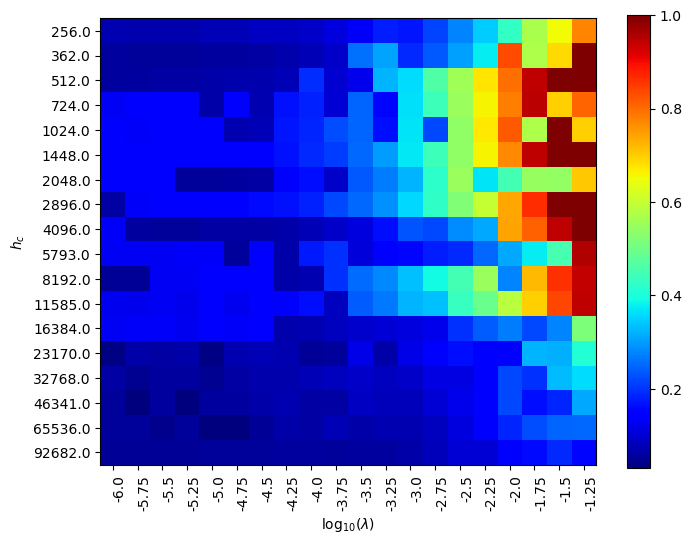

In [51]:
numbers_of_aval = np.zeros((len(heightRange), len(lambdaRange), 4))
print(np.shape(numbers_of_aval))

counter = 0
for j in range(len(heightRange)): 
    for k in range(len(lambdaRange)): 
        numbers_of_aval[j,k,0] = counter + 1000
        numbers_of_aval[j,k,1] = number_sizes[counter, 1]
        numbers_of_aval[j,k,2] = number_areas[counter, 1]
        numbers_of_aval[j,k,3] = number_lifetimes[counter, 1]
        counter += 1

        
fig, ax1 = plt.subplots(1, 1, figsize = (8,6), dpi=100, frameon=False)
im = ax1.imshow(numbers_of_aval[:,:,1]/5000000, cmap=plt.cm.jet)

ax1.set_yticks(np.arange(len(heightRange)))
ax1.set_yticklabels(heightRange)
ax1.set_ylabel(r"$h_c$")

ax1.set_xticks(np.arange(len(lambdaRange)))
ax1.set_xticklabels(np.log10(lambdaRange))
plt.setp(ax1.get_xticklabels(),rotation=90, ha="right", rotation_mode="anchor")
ax1.set_xlabel(r"$\log_{10}(\lambda)$")

fig.colorbar(im, ax=ax1)
# plt.savefig("Plots_fortran/number_check_2d.png", dpi=240, bbox_inches='tight')

In [54]:
fig, ax1 = plt.subplots(1,1,figsize=(10, 5), dpi=150, frameon=True)
colors = plt.cm.jet(np.linspace(0,1,len(heightRange)))

for j in range(len(heightRange)): 
    ax1.plot(lambdaRange, numbers_of_aval[j,:,1]/5000000, '.-', color=colors[j], label=r"$h_c=$"+str(heightRange[j]))

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel("Percent of 5,000,000 cluster finished")
ax1.set_xlabel(r"dissipation - $\lambda$")
ax1.set_ylim([1e-2, 1e0+0.1])
ax1.legend(fontsize=5)
# plt.savefig("Plots_fortran/number_check.png", dpi=240, bbox_inches='tight')

## Consistency of $\tau$ exponents

Does $\tau$ exponents stay consistent with changing $\lambda$ for fixed $h_c$?

In [30]:
def plotD_tau_consistent(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[5:16], y[5:16], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[5], x[16],40)
    ax1.plot(x, y, '.', label = r"$\lambda=$"+str(round(params[2],6)))
    ax1.plot(xpa, pa(xpa),linestyle='--', color='black')
#              label=r'$\tau_s = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
#     ax1.fill_between(xpa, -10, 0, 
#                     facecolor='red', alpha=0.3)
    
    # ---------------------------------------------------- #
    taus = round(-za[0],3)
    errors = round(perra[0], 4)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[5:13], y[5:13], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[5], x[13],40)
    ax3.plot(x, y, '.', label = r"$\lambda=$"+str(round(params[2],6)))
    ax3.plot(xpa, pa(xpa),linestyle='--', color='black') 
#              label=r'$\tau_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
#     ax3.fill_between(xpa, -10, 0, 
#                     facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    taua = round(-za[0],3)
    errora = round(perra[0], 4)
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    
    za, cova = np.polyfit(x[5:14], y[5:14], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[5], x[14],40)
    ax2.plot(x, y, '.', label = r"$\lambda=$"+str(round(params[2],6)))
    ax2.plot(xpa, pa(xpa),linestyle='--', color='black') 
#              label=r'$\tau_D = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
#     ax2.fill_between(xpa, -10, 0, 
#                     facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    taud = round(-za[0],3)
    errord = round(perra[0], 4)

    return params[2], params[3], [taus, taua, taud], [errors, errora, errord]

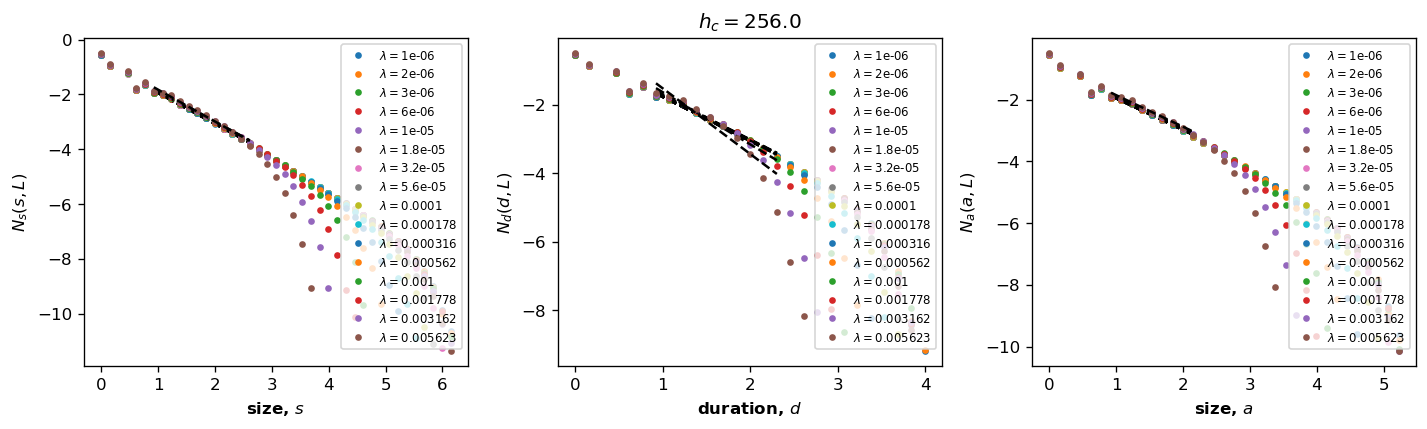

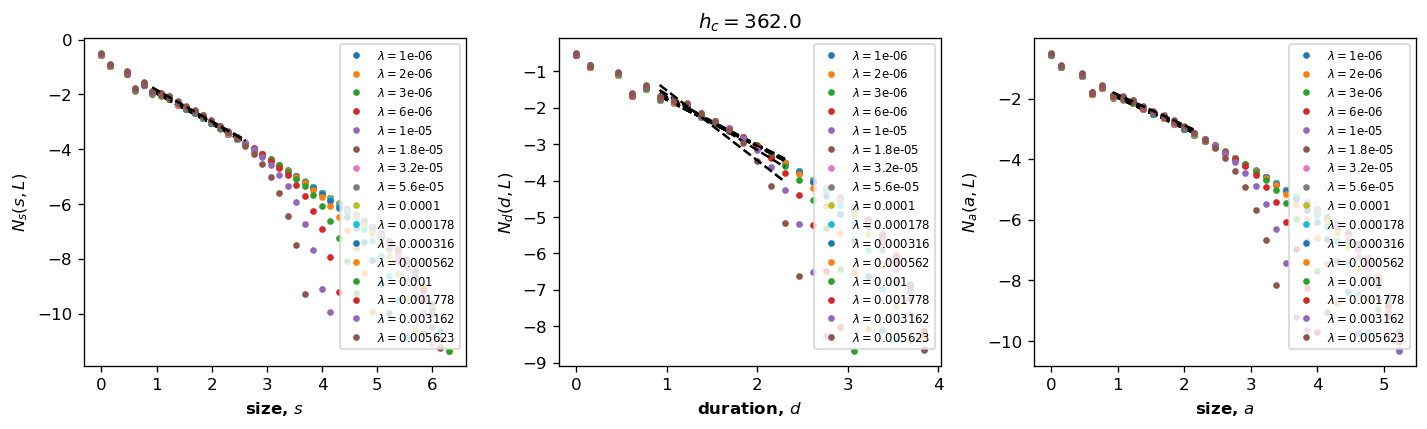

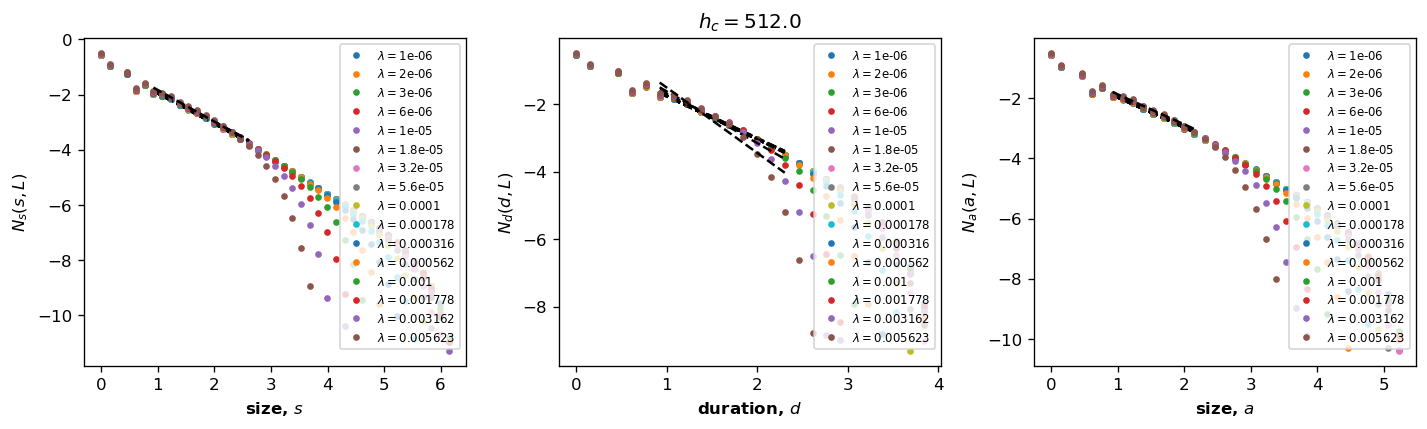

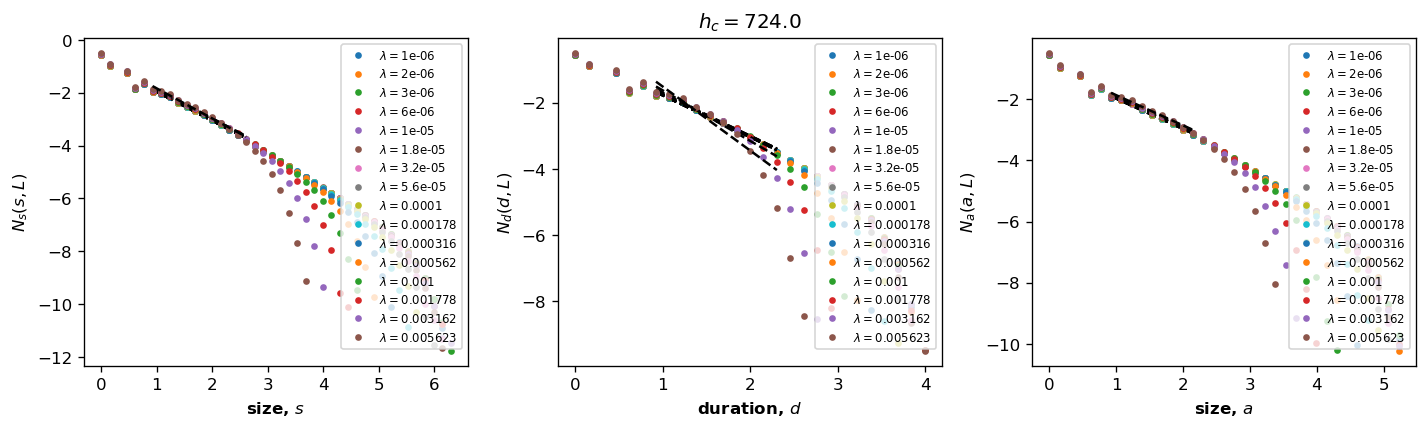

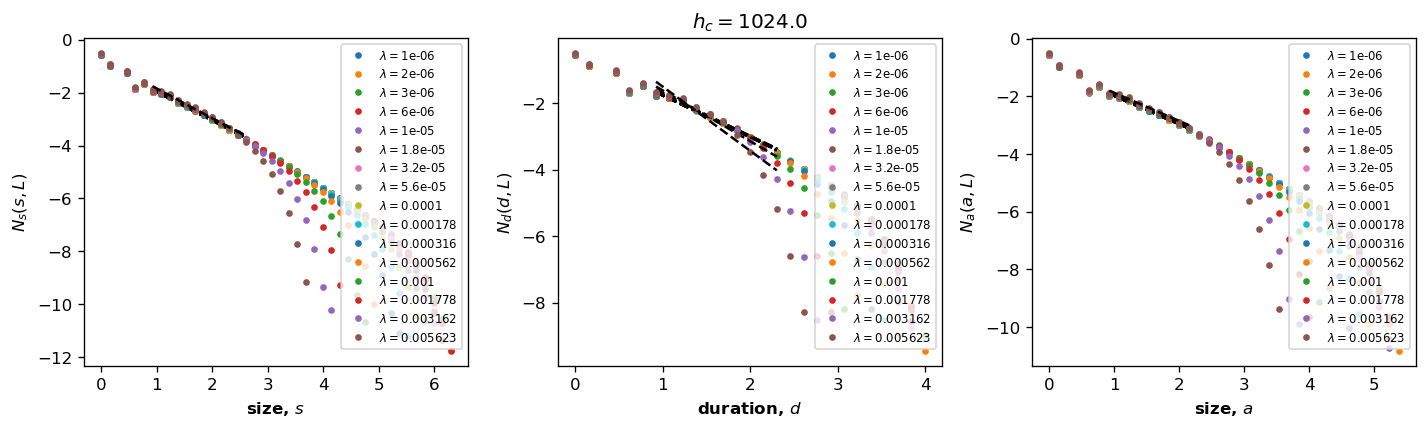

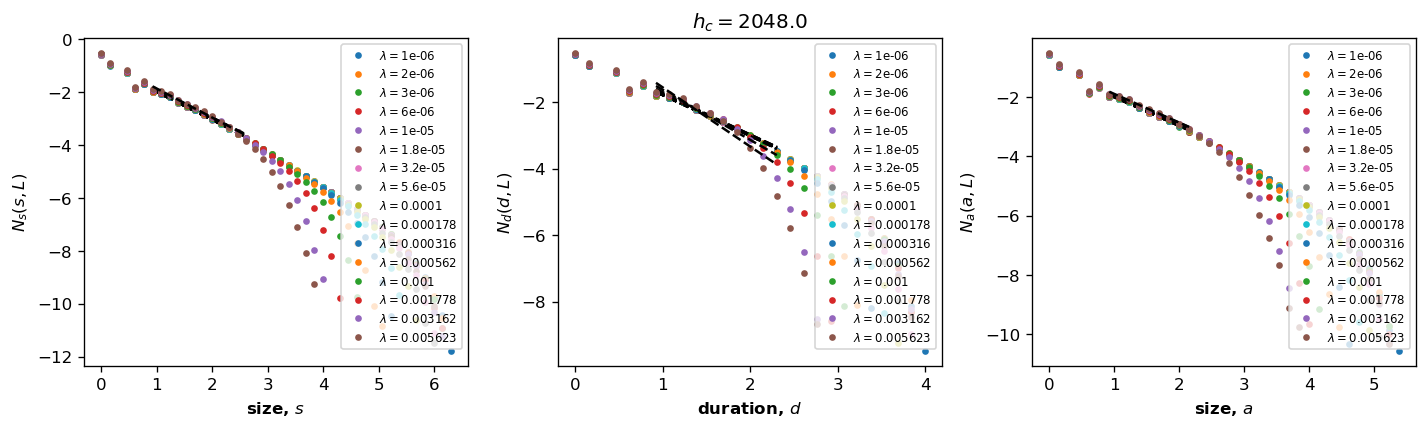

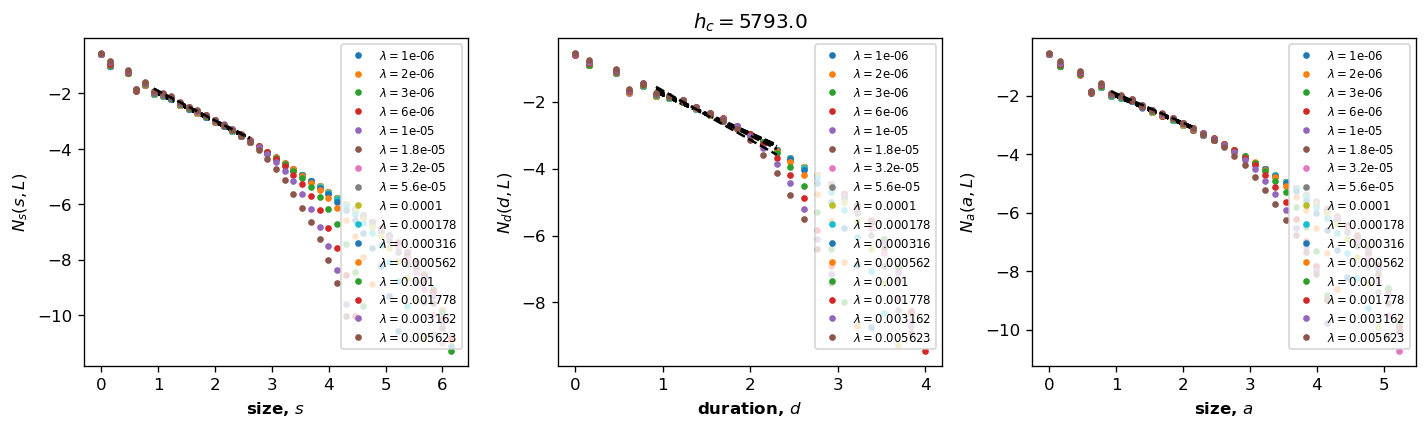

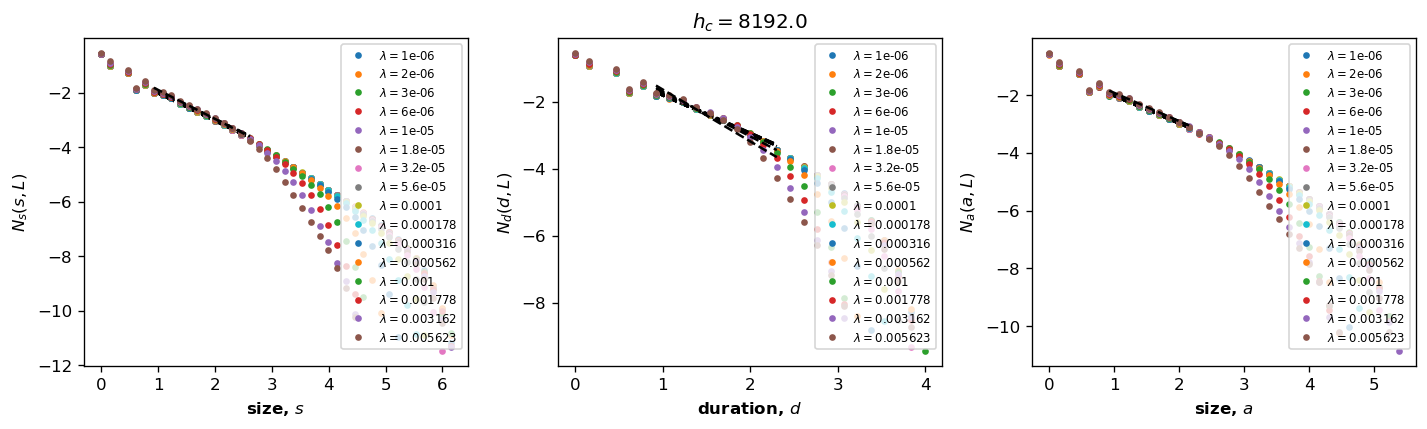

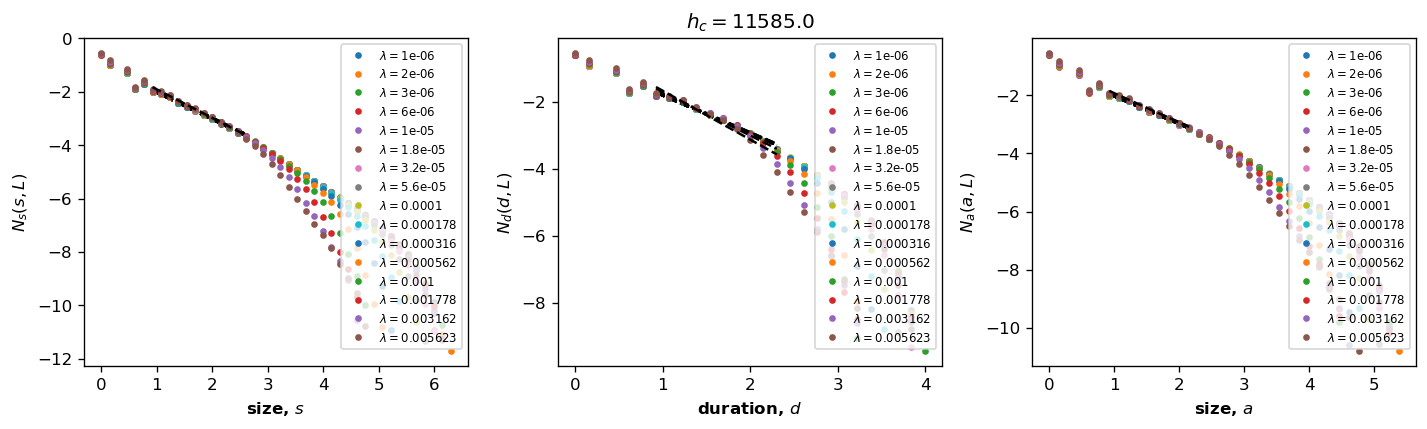

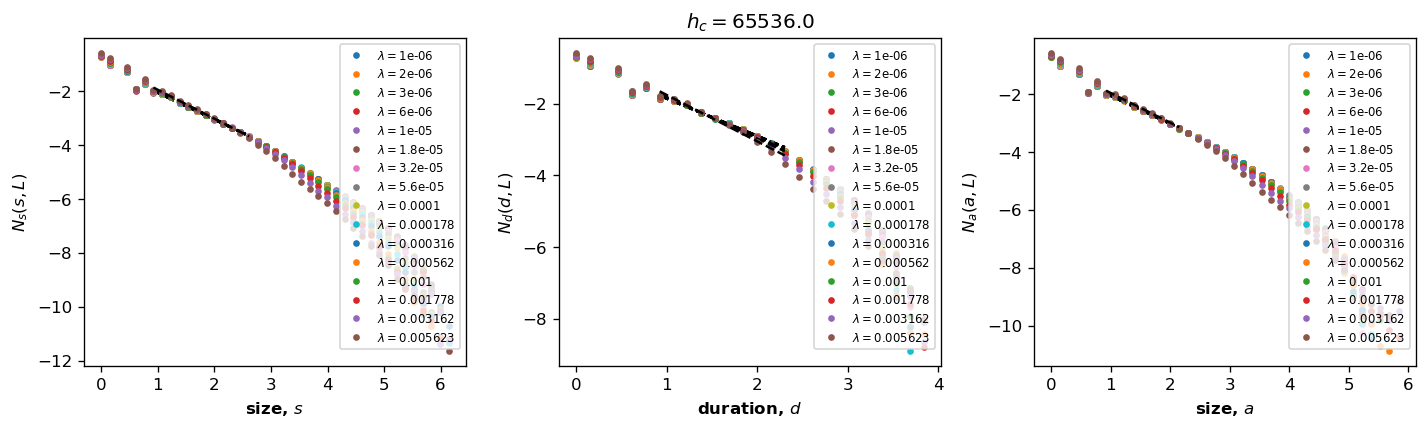

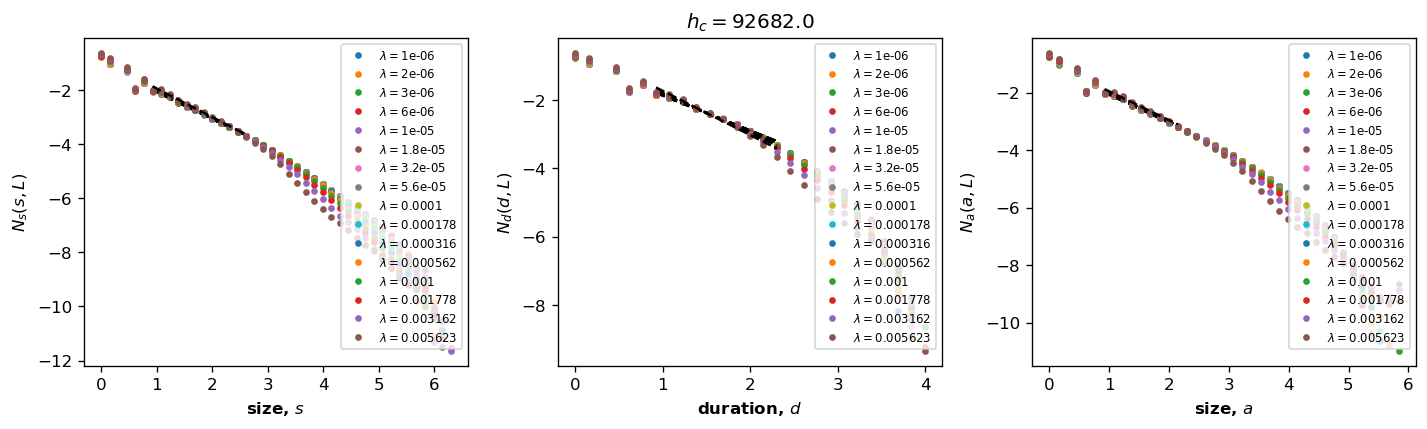

In [72]:
lambda_cons = []
tau_s_cons = []
tau_a_cons = []
tau_d_cons = []
tau_s_cons_err = []
tau_a_cons_err = []
tau_d_cons_err = []

for hc in heightRange: 
    indexRange = []
    for j in range(len(fixed_SetRange[0,:])): 
        if fixed_SetRange[0,j] == hc:
            filename = "Histo_fortran/sp_hist" + str(j+1000) + "_s.txt"
            if path.exists(filename):
                indexRange += [j+1000] 
                
    seed0 = indexRange[0] # Run/seed with smallest \lambda
    print("Working on seed"+str(seed0)+"...", end='\r')

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4), dpi=120, frameon=True)
    
    for seed0 in indexRange[:16]: 
        lamb, h_c, new_exp, new_err = plotD_tau_consistent(seed0, 'r')
        lambda_cons += [lamb]
        tau_s_cons += [new_exp[0]]
        tau_a_cons += [new_exp[1]]
        tau_d_cons += [new_exp[2]]
        tau_s_cons_err += [new_err[0]]
        tau_a_cons_err += [new_err[1]]
        tau_d_cons_err += [new_err[2]]

    # -- Decoration --
    ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
    ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
    ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
    ax1.legend(loc=1, fontsize=7)
    ax2.legend(loc=1, fontsize=7)
    ax3.legend(loc=1, fontsize=7)
    ax2.set_title(r"$h_c=$"+str(hc))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
#     plt.savefig("Plots_fortran/hc"+str(hc)+"_tau_x.png", dpi=240, bbox_inches='tight')
#     plt.close()




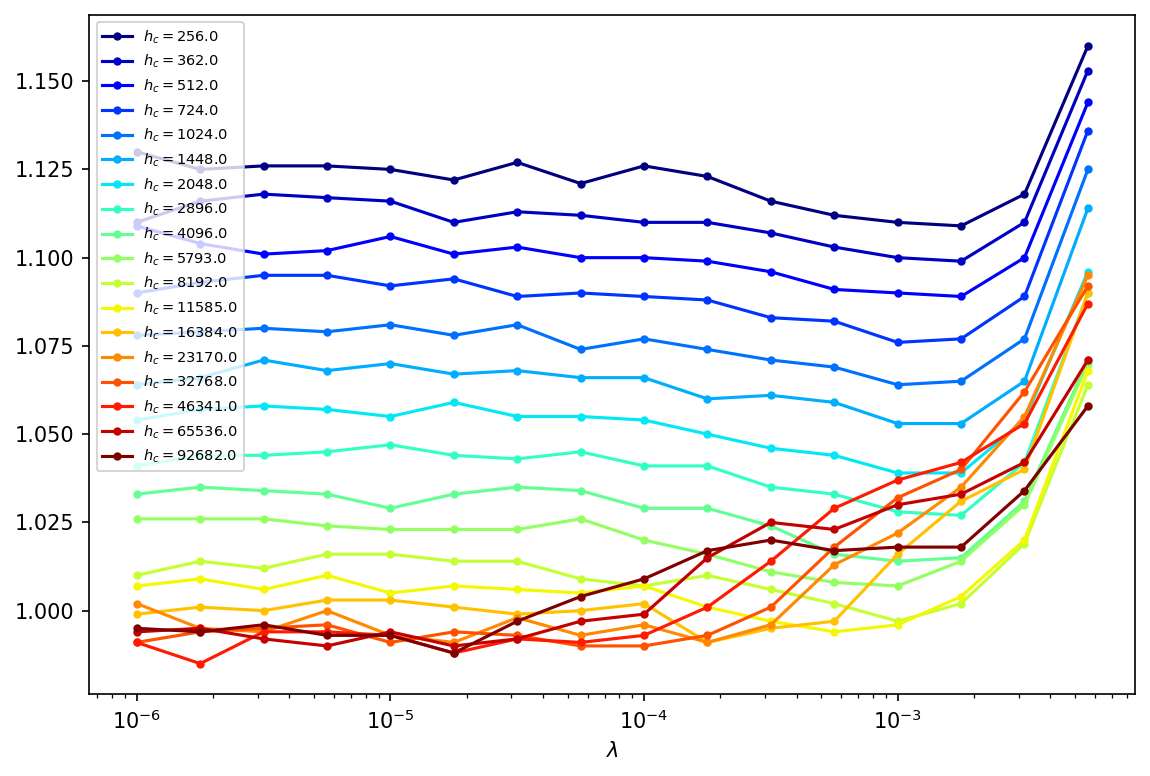

In [74]:
lambda_cons_ar = np.asarray(lambda_cons).reshape(len(heightRange),16)
tau_s_cons_ar = np.asarray(tau_s_cons).reshape(len(heightRange),16)
tau_a_cons_ar = np.asarray(tau_a_cons).reshape(len(heightRange),16)
tau_d_cons_ar = np.asarray(tau_d_cons).reshape(len(heightRange),16)

tau_s_cons_err_ar = np.asarray(tau_s_cons_err).reshape(len(heightRange),16)
tau_a_cons_err_ar = np.asarray(tau_a_cons_err).reshape(len(heightRange),16)
tau_d_cons_err_ar = np.asarray(tau_d_cons_err).reshape(len(heightRange),16)

lambda_cons_ar[1,:]

fig, ax1 = plt.subplots(1,1,figsize=(9, 6), dpi=150, frameon=True)
colors = plt.cm.jet(np.linspace(0,1,len(heightRange)))

for hc_i, hc in enumerate(heightRange): 
    ax1.plot(lambda_cons_ar[hc_i,:], tau_s_cons_ar[hc_i,:], '.-', color=colors[hc_i], label=r"$h_c=$"+str(hc))

ax1.set_xscale('log')
ax1.set_xlabel(r'$\lambda$')
ax1.legend(fontsize=7)
plt.savefig("Plots_fortran/expon_tau_s_cons.png", dpi=240, bbox_inches='tight')

fig, ax1 = plt.subplots(1,1,figsize=(9, 6), dpi=150, frameon=True)
colors = plt.cm.jet(np.linspace(0,1,len(heightRange)))

for hc_i, hc in enumerate(heightRange): 
    ax1.plot(lambda_cons_ar[hc_i,:], tau_a_cons_ar[hc_i,:], '.-', color=colors[hc_i], label=r"$h_c=$"+str(hc))

ax1.set_xscale('log')
ax1.set_xlabel(r'$\lambda$')
ax1.legend(fontsize=7)
plt.savefig("Plots_fortran/expon_tau_a_cons.png", dpi=240, bbox_inches='tight')

fig, ax1 = plt.subplots(1,1,figsize=(9, 6), dpi=150, frameon=True)
colors = plt.cm.jet(np.linspace(0,1,len(heightRange)))

for hc_i, hc in enumerate(heightRange): 
    ax1.plot(lambda_cons_ar[hc_i,:], tau_d_cons_ar[hc_i,:], '.-', color=colors[hc_i], label=r"$h_c=$"+str(hc))

ax1.set_xscale('log')
ax1.set_xlabel(r'$\lambda$')
ax1.legend(fontsize=7)
plt.savefig("Plots_fortran/expon_tau_d_cons.png", dpi=240, bbox_inches='tight')

In [73]:
lambda_cons_ar[1,:]

for hc_i, hc in enumerate(heightRange): 

    fig, ax1 = plt.subplots(1,1,figsize=(9, 2), dpi=150, frameon=True)

    ax1.errorbar(lambda_cons_ar[hc_i,:], tau_s_cons_ar[hc_i,:], yerr=tau_s_cons_err_ar[hc_i,:],label=r"$\tau_s$")
    ax1.errorbar(lambda_cons_ar[hc_i,:], tau_a_cons_ar[hc_i,:], yerr=tau_a_cons_err_ar[hc_i,:],label=r"$\tau_a$")
    ax1.errorbar(lambda_cons_ar[hc_i,:], tau_d_cons_ar[hc_i,:], yerr=tau_d_cons_err_ar[hc_i,:],label=r"$\tau_d$")

    ax1.set_xscale('log')
    ax1.set_xlabel(r'$\lambda$')
    ax1.legend(fontsize=7)
    plt.savefig("Plots_fortran/expon_tau_cons"+str(hc)+".png", dpi=240, bbox_inches='tight')
    plt.close()



# L=100 Check

In [4]:
heightRange = np.round(2**(np.unique(np.arange(8,17, 0.5))))[:1]
lambdaRange = 10**np.arange(-6, -1, 0.25).astype(float)

setRange = np.zeros((len(heightRange), len(lambdaRange),2))

for j in range(len(heightRange)): 
    for k in range(len(lambdaRange)): 
        setRange[j,k,0] = heightRange[j]
        setRange[j,k,1] = lambdaRange[k]

fixed_SetRange = setRange.transpose(2,0,1).reshape(2,-1)
print(np.shape(fixed_SetRange))


## Determine which seeds satisfy the desired h_c
hc = 256
indexRange = []
for j in range(len(fixed_SetRange[0,:])): 
    if fixed_SetRange[0,j] == hc:
        indexRange += [j+1000]
        
print(indexRange)
print(heightRange)



(2, 20)
[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019]
[256.]


## Functions

In [19]:
def plotSizes(seed, filetype):
    """
    Plot log-log size histogram (log-binned). Reads from pre-histogramed files""
    """
    filename = "Histo_fortran/L100/sp_hist" + str(seed) + "_" + filetype + ".txt"
    
    ## Grab the parameters (first line, commented with '#')
    f=open(filename, "r")
    f1 = f.readlines()
    params = [float(i) for i in f1[0][1:].split(',')]
    
    ## Read the histogram array using Numpy commands. 
    z = np.loadtxt(filename, delimiter=',', comments='#')
    return z[:,0], z[:,1], params

def plotD_tau(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[8:26], y[8:26], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[26],40)
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    ax1.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_s = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax1.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    
    # ---------------------------------------------------- #
    taus = round(-za[0],3)
    errors = round(perra[0], 4)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[6:23], y[6:23], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[23],40)
    ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    ax3.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax3.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    taua = round(-za[0],3)
    errora = round(perra[0], 4)
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    
    za, cova = np.polyfit(x[6:14], y[6:14], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[14],40)
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    ax2.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_D = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax2.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    # ---------------------------------------------------- #
    taud = round(-za[0],3)
    errord = round(perra[0], 4)

    return params[2], params[3], [taus, taua, taud], [errors, errora, errord]

def func_sizeC(s, tau, s_c, A):
    return A - tau * s -  10**(s) / s_c / np.log(10)

def plotD_plotSizes(seed, c, tauList, tau_err, plotBool):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    tau = tauList[0]; er=tau_err[0]
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt, pcov = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr = np.sqrt(np.diag(pcov))

    if plotBool: 
        ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
        ax1.plot(x, func_sizeC(x, *popt), color=c)
    
    
    ## Sizes w/o double counting
    x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
    tau = tauList[1]; er=tau_err[1]
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt3, pcov3 = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr3 = np.sqrt(np.diag(pcov3))
    
    if plotBool: 
        ax3.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
        ax3.plot(x, func_sizeC(x, *popt3), color=c)
    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    tau = tauList[2]; er=tau_err[2]
    initGuess = np.asarray([tau, 1,    1])
    paramBounds =         ((tau-er, -1e8, -100), 
                           (tau+er, 1e8,  100))
    popt2, pcov2 = curve_fit(func_sizeC, x, y, p0=initGuess, bounds=paramBounds)
    perr2 = np.sqrt(np.diag(pcov2))

    if plotBool: 
        ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
        ax2.plot(x, func_sizeC(x, *popt2), color=c)
    return params[2], params[3], [popt[0], popt[1],popt2[0], popt2[1],popt3[0], popt3[1]], [perr[0], perr[1], perr2[0], perr2[1], perr3[0], perr3[1]]

def read_chi_disp(hc, filetype): 
    filename = "Histo_fortran/L100/chi_"+filetype+str(hc)+".txt"
    
    ## Read the histogram array using Numpy commands. 
    z = np.loadtxt(filename, delimiter=',', comments='#')
    return z[0,:], z[1,:]

## Compute $\tau$

In [39]:
tau_s = []
tau_a = []
tau_d = []
tau_s_err = []
tau_a_err = []
tau_d_err = []

for hc in heightRange: 
    indexRange = []
    for j in range(len(fixed_SetRange[0,:])): 
        if fixed_SetRange[0,j] == hc:
            filename = "Histo_fortran/L100/sp_hist" + str(j+980) + "_s.txt"
            if path.exists(filename):
                indexRange += [j+980] 
                
    seed0 = indexRange[0] # Run/seed with smallest \lambda
    print("Working on seed"+str(seed0)+"...", end='\r')

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,3), dpi=120, frameon=True)

    lamb, h_c, new_exp, new_err = plotD_tau(seed0, 'r')

    tau_s += [new_exp[0]]
    tau_a += [new_exp[1]]
    tau_d += [new_exp[2]]
    tau_s_err += [new_err[0]]
    tau_a_err += [new_err[1]]
    tau_d_err += [new_err[2]]

    # -- Decoration --
    ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
    ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
    ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
    ax1.legend(loc=1, fontsize=7)
    ax2.legend(loc=1, fontsize=7)
    ax3.legend(loc=1, fontsize=7)
    ax2.set_title(r"$h_c=$"+str(hc))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig("Plots_fortran/hc"+str(hc)+"_tau_x.png", dpi=240, bbox_inches='tight')
#     plt.close()



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


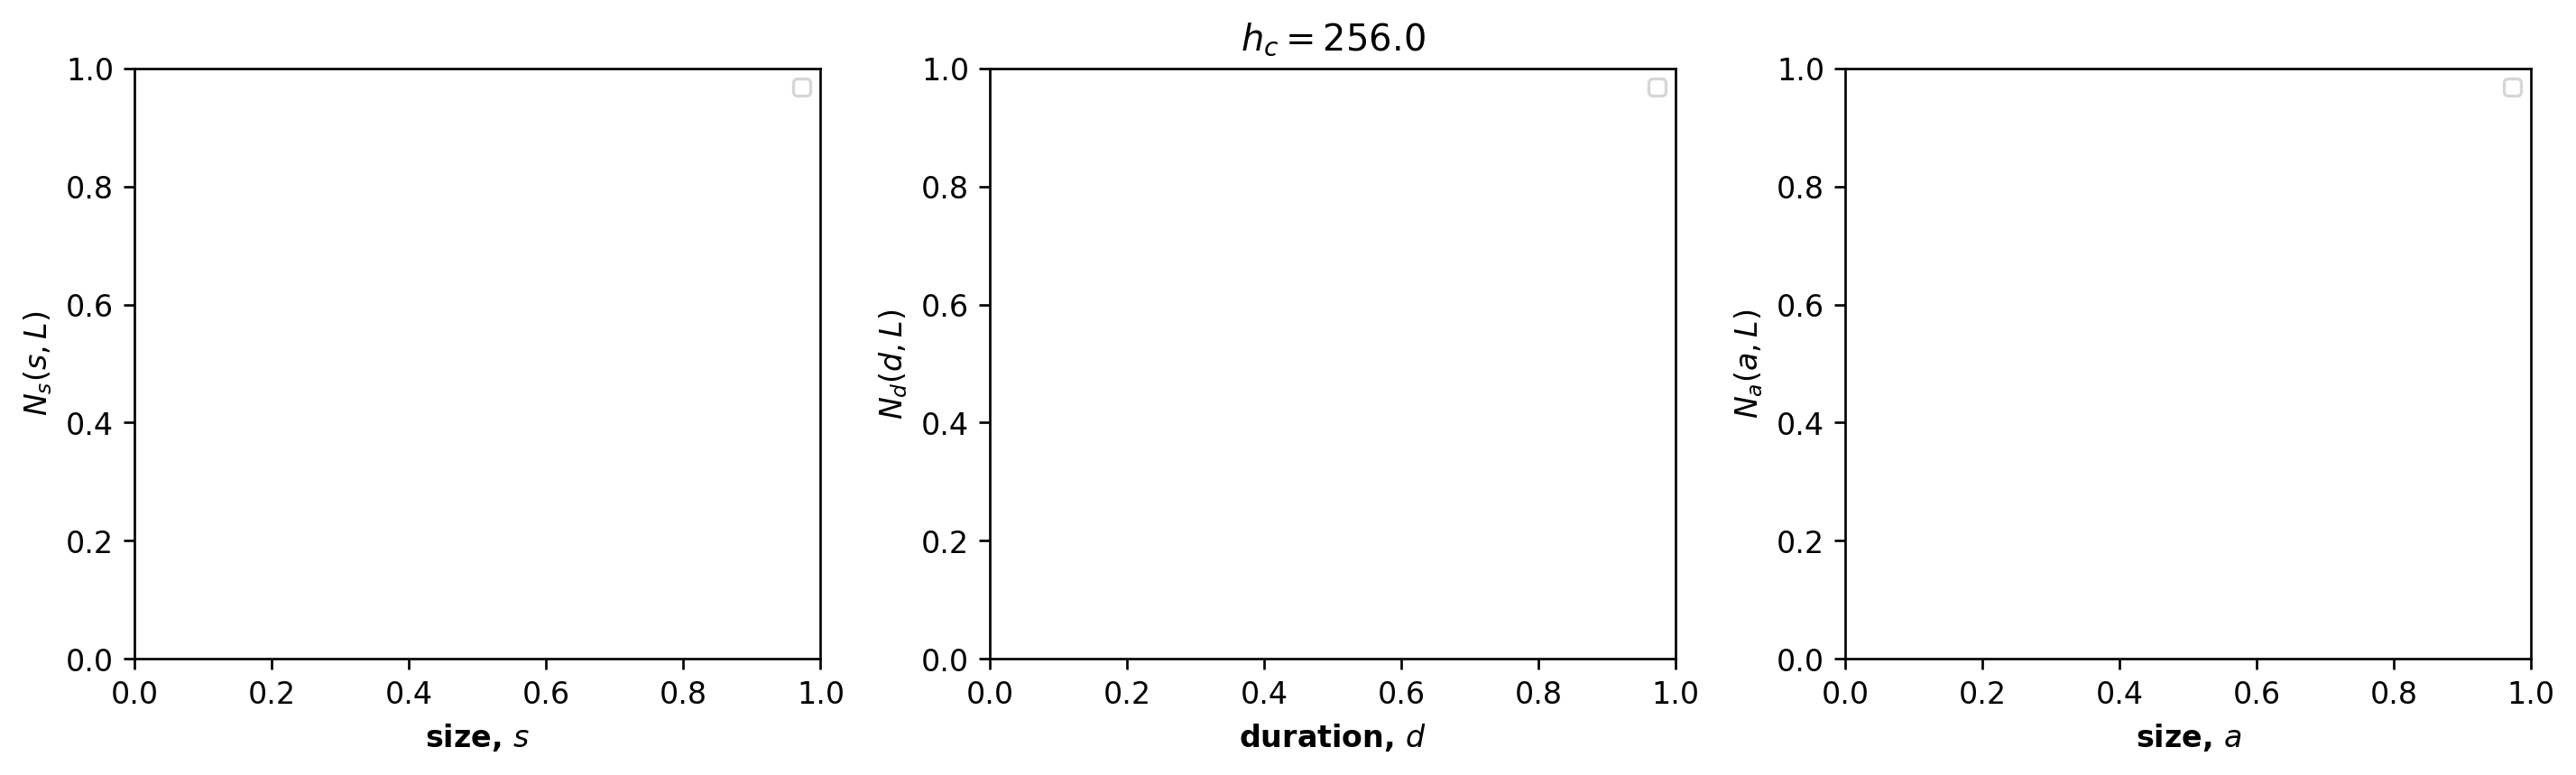

In [14]:
for hc in heightRange[::10]:
    indexRange = []
    for j in range(len(fixed_SetRange[0,:])): 
        if fixed_SetRange[0,j] == hc:
            filename = "Histo_fortran/L100/sp_hist" + str(j+1000) + "_s.txt"
            if path.exists(filename):
                indexRange += [j+1000] 
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4), dpi=240, frameon=False)
    for seed_i, seed in enumerate(indexRange[:-4:4]): 
        
        ## Sizes w/ double counting
        x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
        ax1.plot(x, y, '.', label = r"$\lambda=$"+str(round(params[2],6)))

        ## Sizes w/o double counting
        x,y,params = plotSizes(seed, filetype='a');  x = np.log10(x); y = np.log10(y)
        ax3.plot(x, y, '.', label = r"$\lambda=$"+str(round(params[2],6)))

        ## Durations
        x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
        ax2.plot(x, y, '.', label = r"$\lambda=$"+str(round(params[2],6)))

    # -- Decoration --
    ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
    ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
    ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
    ax1.legend(loc=1, fontsize=7)
    ax2.legend(loc=1, fontsize=7)
    ax3.legend(loc=1, fontsize=7)
    ax2.set_title(r"$h_c=$"+str(hc))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig("Plots_fortran/hc"+str(hc)+"_tau_x.png", dpi=240, bbox_inches='tight')
#     plt.close()


## Compute $\sigma$

In [40]:
sigma_s = []
sigma_a = []
sigma_d = []
sigma_s_err = [] 
sigma_a_err = []
sigma_d_err = []


for hc_i, hc in enumerate(heightRange): 
    print(hc, end=' ')
    indexRange = []
    for j in range(len(fixed_SetRange[0,:])): 
        if fixed_SetRange[0,j] == hc:
            filename = "Histo_fortran/L100/sp_hist" + str(j+980) + "_s.txt"
            if path.exists(filename):
                indexRange += [j+980] 

    lambdas = []
    s_c = []; a_c = []; d_c = []

    tauList = [tau_s[hc_i], tau_a[hc_i], tau_d[hc_i]]
    tauErrList = [tau_s_err[hc_i], tau_a_err[hc_i], tau_d_err[hc_i]]

    for i in range(len(indexRange[:-1])):
        c = 'r'
        lamb, h_c, new_exp, new_err = plotD_plotSizes(indexRange[i], c, tauList, tauErrList, plotBool=False)
        lambdas += [lamb]
        s_c += [new_exp[1]]
        a_c += [new_exp[5]]
        d_c += [new_exp[3]]

    # ---------- Plot of Exponents while lambda -> 0 --------- #
    # ---------- Fitting to compute \sigma's  ---------------- #
    fit_min = 13
    fit_max=-1

    slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log10(np.asarray(lambdas[fit_min:fit_max])), np.log10(np.asarray(s_c[fit_min:fit_max])))
    slopeA, interceptA, r_valueA, p_valueA, std_errA = stats.linregress(np.log10(np.asarray(lambdas[fit_min:fit_max])), np.log10(np.asarray(a_c[fit_min:fit_max])))
    slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log10(np.asarray(lambdas[fit_min:fit_max])), np.log10(np.asarray(d_c[fit_min:fit_max])))

    xs = np.linspace(-4,-1,7)
    lineS = slopeS * xs + interceptS
    lineA = slopeA * xs + interceptA
    lineD = slopeD * xs + interceptD

    sigma_s += [-1/slopeS]
    sigma_a += [-1/slopeA]
    sigma_d += [-1/slopeD]
    sigma_s_err += [std_errS]
    sigma_a_err += [std_errA]
    sigma_d_err += [std_errD]

    # -------------------- Create Figure  -------------------- #
    fig2, (ax4, ax5, ax6) = plt.subplots(1,3,figsize=(9, 3), dpi=120, frameon=True)
    ax4.plot(np.asarray(lambdas),np.asarray(s_c), 'ro-', 
             label=r'$\sigma_s \approx $' + str(round(-1/slopeS, 4)) + '$\pm$' + str(round(std_errS, 4)))
    ax5.plot(np.asarray(lambdas),np.asarray(a_c),'bo-', 
             label=r'$\sigma_a \approx $' + str(round(-1/slopeA, 4)) + '$\pm$' + str(round(std_errA, 4)))
    ax6.plot(np.asarray(lambdas),np.asarray(d_c),'go-', 
             label=r'$\sigma_D \approx $' + str(round(-1/slopeD, 4)) + '$\pm$' + str(round(std_errD, 4)))

    # print(-1/slopeS, -1/slopeD)
    ax4.plot(10**xs, 10**lineS, '--', color='grey')
    ax5.plot(10**xs, 10**lineA, '--', color='grey')
    ax6.plot(10**xs, 10**lineD, '--', color='grey')
    
    
    ax4.fill_between(lambdas[fit_min:fit_max], 1e1, 1e5, facecolor='red', alpha=0.3)
    ax5.fill_between(lambdas[fit_min:fit_max], 1e1, 1e5, facecolor='blue', alpha=0.3)
    ax6.fill_between(lambdas[fit_min:fit_max], 1e1, 1e5, facecolor='green', alpha=0.3)

    # -- Decoration --
    ax4.legend(fontsize=8); 
    ax5.legend(fontsize=8); 
    ax6.legend(fontsize=8); 
    ax4.set_xscale('log'); ax4.set_yscale('log'); ax4.set_xlabel('dissipation, $\lambda$'); ax4.set_ylabel('$s_c$')
    ax5.set_xscale('log'); ax5.set_yscale('log'); ax5.set_xlabel('dissipation, $\lambda$'); ax6.set_ylabel('$D_c$')
    ax6.set_xscale('log'); ax6.set_yscale('log'); ax6.set_xlabel('dissipation, $\lambda$'); ax5.set_ylabel('$a_c$')
    ax5.set_title(r"$h_c=$"+str(hc))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("Plots_fortran/hc"+str(hc)+"_sigma_x_L100.png", dpi=240, bbox_inches='tight')
#     plt.close()


256.0 

## Compute $\gamma$

In [25]:
gamma_s = []
gamma_a = []
gamma_d = []
gamma_s_err = []
gamma_a_err = []
gamma_d_err = []

for hc in heightRange: 
    print(hc, end=' ')
    
    fit_min = 13
    fit_max= -2

    lambda_s, chi_s = read_chi_disp(hc,'s')
    lambda_a, chi_a = read_chi_disp(hc,'a')
    lambda_d, chi_d = read_chi_disp(hc,'d')

    loglambd_s = np.log10(lambda_s); logchi_s = np.log10(chi_s)
    loglambd_a = np.log10(lambda_a); logchi_a = np.log10(chi_a)

    # -------------------- Create Figure  -------------------- #       
    fig1, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4), dpi=120, frameon=True)
    ax1.plot(loglambd_s, logchi_s, 'ro-')
    ax2.plot(loglambd_a, logchi_a, 'bo-')

    zs, covs = np.polyfit(loglambd_s[fit_min:fit_max], logchi_s[fit_min:fit_max], 1, cov=True)
    ps = np.poly1d(zs)
    perrs = np.sqrt(np.diag(covs))
    xps = np.linspace(-5,-1,40)
    ax1.plot(xps, ps(xps),linestyle='--', color='grey', 
             label='$\gamma_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
    ax1.fill_between(loglambd_a[fit_min:fit_max], 1, 6, 
                    facecolor='red', alpha=0.3)
    gamma_s += [-zs[0]]
    gamma_s_err += [round(perrs[0], 4)]

    za, cova = np.polyfit(loglambd_a[fit_min:fit_max], logchi_a[fit_min:fit_max], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(-5,-1,40)
    ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label='$\gamma_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax2.fill_between(loglambd_a[fit_min:fit_max], 1, 5, 
                    facecolor='blue', alpha=0.3)
    gamma_a += [-za[0]]
    gamma_a_err += [round(perra[0], 4)]

    # -- Decoration --
    ax1.set_ylabel(r'repsonse function, $\log\chi_s(\lambda)$',fontweight='bold')
    ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
    ax1.legend(loc=3, fontsize=8)

    ax2.set_ylabel(r'repsonse function, $\log\chi_a(\lambda)$',fontweight='bold')
    ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
    ax2.legend(loc=3, fontsize=8)

    loglambd_d = np.log10(lambda_d); logchi_d = np.log10(chi_d)

    # -------------------- Create Figure  -------------------- #       
    ax3.plot(loglambd_d, logchi_d, 'go-')

    zd, covd = np.polyfit(loglambd_d[fit_min:fit_max], logchi_d[fit_min:fit_max], 1, cov=True)
    pd = np.poly1d(zd)
    perrd = np.sqrt(np.diag(covd))
    xpd = np.linspace(-5,-1,40)
    ax3.plot(xpd, pd(xpd),linestyle='--', color='grey', 
             label='$\gamma_d = $'+str(round(-zd[0],3))+'$\pm$'+str(round(perrd[0], 4)))
    ax3.fill_between(loglambd_a[fit_min:fit_max], 0, 4, #where=y > theta,
                    facecolor='green', alpha=0.3)
    gamma_d += [-zd[0]]
    gamma_d_err += [round(perrd[0], 4)]

    # -- Decoration --
    ax3.set_ylabel(r'repsonse function, $\log\chi(\lambda)$',fontweight='bold')
    ax3.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
    ax3.legend(loc=3, fontsize=8)
    
    ax2.set_title(r"$h_c=$"+str(hc))
    
    plt.savefig("Plots_fortran/hc"+str(hc)+"_gamma_x_L100.png", dpi=240, bbox_inches='tight')
#     plt.close()



256.0 

## Compute $\nu$ - Correlation length 

$$\xi \sim \lambda^{-\nu}$$

In [26]:
def read_xi_disp(hc, filetype): 
    filename = "Histo_fortran/L100/xi_"+filetype+str(hc)+".txt"
    
    ## Read the histogram array using Numpy commands. 
    z = np.loadtxt(filename, delimiter=',', comments='#')
    return z[0,:], z[1,:]

In [32]:
nu_s = []
nu_a = []
nu_s_err = []
nu_a_err = []

for hc in heightRange: 
    print(hc, end=' ')
    
    fit_min = 10
    fit_max= -5

    lambda_s, xi_s = read_xi_disp(hc,'s')
    lambda_a, xi_a = read_xi_disp(hc,'a')

    loglambd_s = np.log10(lambda_s); logxi_s = np.log10(xi_s)
    loglambd_a = np.log10(lambda_a); logxi_a = np.log10(xi_a)

    # -------------------- Create Figure  -------------------- #       
    fig1, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3), dpi=120, frameon=True)
    ax1.plot(loglambd_s, logxi_s, 'ro-')
    ax2.plot(loglambd_a, logxi_a, 'bo-')

    zs, covs = np.polyfit(loglambd_s[fit_min:fit_max], logxi_s[fit_min:fit_max], 1, cov=True)
    ps = np.poly1d(zs)
    perrs = np.sqrt(np.diag(covs))
    xps = np.linspace(-5,-1,40)
    ax1.plot(xps, ps(xps),linestyle='--', color='grey', 
             label='$\gamma_s = $'+str(round(-zs[0],3))+'$\pm$'+str(round(perrs[0], 4)))
    ax1.fill_between(loglambd_a[fit_min:fit_max], 2, 3, 
                    facecolor='red', alpha=0.3)
    nu_s += [-zs[0]]
    nu_s_err += [round(perrs[0], 4)]

    za, cova = np.polyfit(loglambd_a[fit_min:fit_max], logxi_a[fit_min:fit_max], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(-5,-1,40)
    ax2.plot(xpa, pa(xpa),linestyle='--', color='grey', 
             label='$\gamma_a = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax2.fill_between(loglambd_a[fit_min:fit_max], 2, 3, 
                    facecolor='blue', alpha=0.3)
    nu_a += [-za[0]]
    nu_a_err += [round(perra[0], 4)]

    # -- Decoration --
    ax1.set_ylabel(r'correlation length, $\log\xi_s(\lambda)$',fontweight='bold')
    ax1.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
    ax1.legend(loc=3, fontsize=8)

    ax2.set_ylabel(r'correlation length, $\log\xi_a(\lambda)$',fontweight='bold')
    ax2.set_xlabel(r'dissipation, $\log\lambda$', fontweight='bold')
    ax2.legend(loc=3, fontsize=8)
    
    ax2.set_title(r"$h_c=$"+str(hc))
    
    plt.savefig("Plots_fortran/hc"+str(hc)+"_nu_x_L100.png", dpi=240, bbox_inches='tight')
#     plt.close()




256.0 

## Data collapse is worse? 

In [44]:
for h_i, hc in enumerate(heightRange): 
    indexRange = []
    for j in range(len(fixed_SetRange[0,:])): 
        if fixed_SetRange[0,j] == hc:
            filename = "Histo_fortran/L100/sp_hist" + str(j+980) + "_s.txt"
            if path.exists(filename):
                indexRange += [j+980] 

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,4), dpi=120, frameon=True)
    seedRange = [indexRange[4], indexRange[8], indexRange[12], indexRange[16]]
    cRange = ['r','g','b', 'y']
    print(hc, end=' ')
    
    for seed_i, seed0 in enumerate(seedRange): 

        ## size 
        x,y,params = plotSizes(seed0, filetype='s');  
        x_re = x * params[2]**(1/sigma_s[h_i])
        y_re = y * params[2]**(-tau_s[h_i]/sigma_s[h_i])
        ax1.plot(x_re, y_re, '.-', color=cRange[seed_i], label = r"$\lambda=$"+str(round(params[2],6)))

        ## area
        x,y,params = plotSizes(seed0, filetype='a');  
        x_re = (x * params[2]**(1 / sigma_a[h_i]))
        y_re = y * ( params[2]**( -tau_a[h_i]/sigma_a[h_i]) )
        ax3.plot(x_re, y_re, '.-', color=cRange[seed_i], label = r"$\lambda=$"+str(round(params[2],6)))

        ## duration
        x,y,params = plotSizes(seed0, filetype='d');  
        x_re = (x * params[2]**(1 / sigma_d[h_i]))
        y_re = y * ( params[2]**( -tau_d[h_i]/sigma_d[h_i]) )
        ax2.plot(x_re, y_re, '.-', color=cRange[seed_i], label = r"$\lambda=$"+str(round(params[2],6)))

    # -- Decoration --
    ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
    ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
    ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax2.set_xscale('log'); ax2.set_yscale('log')
    ax3.set_xscale('log'); ax3.set_yscale('log')
    ax1.legend(loc=1, fontsize=7)
    ax2.legend(loc=1, fontsize=7)
    ax3.legend(loc=1, fontsize=7)
    ax2.set_title(r"$h_c=$"+str(params[3]))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("Plots_fortran/hc"+str(hc)+"_dataCollapse_L100.png", dpi=240, bbox_inches='tight')
#     plt.close()



256.0 

# Bringing back deterministic results

Flashback to completely deterministic results for the Abelian Sandpile model. 

In [101]:
seedRange = np.arange(301, 313, 1)
print(seedRange)

[301 302 303 304 305 306 307 308 309 310 311 312]


In [100]:
def readSizes(seed, filetype):
    "Read the file of avalanche sizes for given seed. "
    
    with open("Data/20191013_determAll/sp" + str(seed) + '_' + filetype + '.txt', "r") as f:
        header=[x for x in next(f)]
        params = [float(x) for x in next(f).split()]
        array = [[int(x) for x in line.split() if '\x00' not in x ] for line in f]

    sizeS_raw = [x[0] for x in array if len(x) >= 1]
    params[1] = int(params[1])
    return sizeS_raw, params

def plotSizes(seed, filetype):
    "Plot log-log size histogram (log-binned) "
    sizeS, params = readSizes(seed,filetype)
    sizeS_Log = np.asarray(sizeS)
    hist, bin_edges = np.histogram(sizeS_Log,bins=np.logspace(0,25,50,base=2),density=True)
    for i in range(len(hist)-1,-1,-1):      # Delete any 0 counts. 
        if hist[i]==0:
            hist = np.delete(hist,i)
            bin_edges = np.delete(bin_edges,i)   
    return bin_edges[:-1], hist, params

## Measure $\tau$

In [188]:
def plotD_plotSizes(seed, c):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)

    za, cova = np.polyfit(x[8:26], y[8:26], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[8], x[26],40)
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
    ax1.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_s = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax1.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    taus = round(-za[0],3)
    errors = round(perra[0], 4)
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    
    za, cova = np.polyfit(x[6:14], y[6:14], 1, cov=True)
    pa = np.poly1d(za)
    perra = np.sqrt(np.diag(cova))
    xpa = np.linspace(x[6], x[14],40)
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
    ax2.plot(xpa, pa(xpa),linestyle='--', color='black', 
             label=r'$\tau_D = $'+str(round(-za[0],3))+'$\pm$'+str(round(perra[0], 4)))
    ax2.fill_between(xpa, -10, 0, 
                    facecolor='red', alpha=0.3)
    taud = round(-za[0],3)
    errord = round(perra[0], 4)

    return params[2], params[3], [taus, taud], [errors, errord]

seed0 = seedRange[-1] # Run/seed with smallest \lambda
print("Working on seed"+str(seed0)+"...", end='\r')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,3), dpi=240, frameon=False)
lamb, h_c, new_exp, new_err = plotD_plotSizes(seed0, 'r')

tau_s = new_exp[0]
tau_d = new_exp[1]
tau_s_err = new_err[0]
tau_d_err = new_err[1]

# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=1, fontsize=7)
ax2.legend(loc=1, fontsize=7)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

print(tau_s, tau_s_err, tau_d, tau_d_err)

1.133 0.0159 1.134 0.0195


## Measure $\sigma$

In [159]:
def func_sizeC(s, tau, s_c, A):
    return A - tau * s -  10**(s) / s_c / np.log(10)

def plotD_plotSizes(seed, c, tauList, tau_err, plotBool):
    
    ## Sizes w/ double counting
    x,y,params = plotSizes(seed, filetype='s');  x = np.log10(x); y = np.log10(y)
    tau = tauList[0]; er=tau_err[0]
    initGuess = np.asarray([tau, 1, 0])
    paramBounds =         ((tau-er, -1e10, -100),
                           (tau+er, 1e10,   100))
    popt, pcov = curve_fit(func_sizeC, x[2:], y[2:], p0=initGuess, bounds=paramBounds)
    perr = np.sqrt(np.diag(pcov))

    if plotBool: 
        ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))
        ax1.plot(x, func_sizeC(x, *popt), color=c)    
    
    ## Durations
    x,y,params = plotSizes(seed, filetype='d');  x = np.log10(x); y = np.log10(y)
    tau = tauList[1]; er=tau_err[1]
    initGuess = np.asarray([tau, 1,    1])
    paramBounds =         ((tau-er, -1e8, -100), 
                           (tau+er, 1e8,  100))
    popt2, pcov2 = curve_fit(func_sizeC, x, y, p0=initGuess, bounds=paramBounds)
    perr2 = np.sqrt(np.diag(pcov2))

    if plotBool: 
        ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))
        ax2.plot(x, func_sizeC(x, *popt2), color=c)
        
    return params[2], params[3], [popt[0], popt[1],popt2[0], popt2[1]], [perr[0], perr[1], perr2[0], perr2[1]]


In [160]:
sigma_s = []; sigma_d = []
sigma_s_err = []; sigma_d_err = []

lambdas = []
s_c = []; d_c = []

tauList = [tau_s, tau_d]
tauErrList = [tau_s_err, tau_d_err]

for i in range(len(seedRange[:-1])):
    c = 'r'
    print(seedRange[i], end=' ')
    lamb, h_c, new_exp, new_err = plotD_plotSizes(seedRange[i], c, tauList, tauErrList, plotBool=False)
    lambdas += [lamb]
    s_c += [new_exp[1]]
    d_c += [new_exp[3]]
    

301 302 303 304 305 306 307 308 309 310 311 

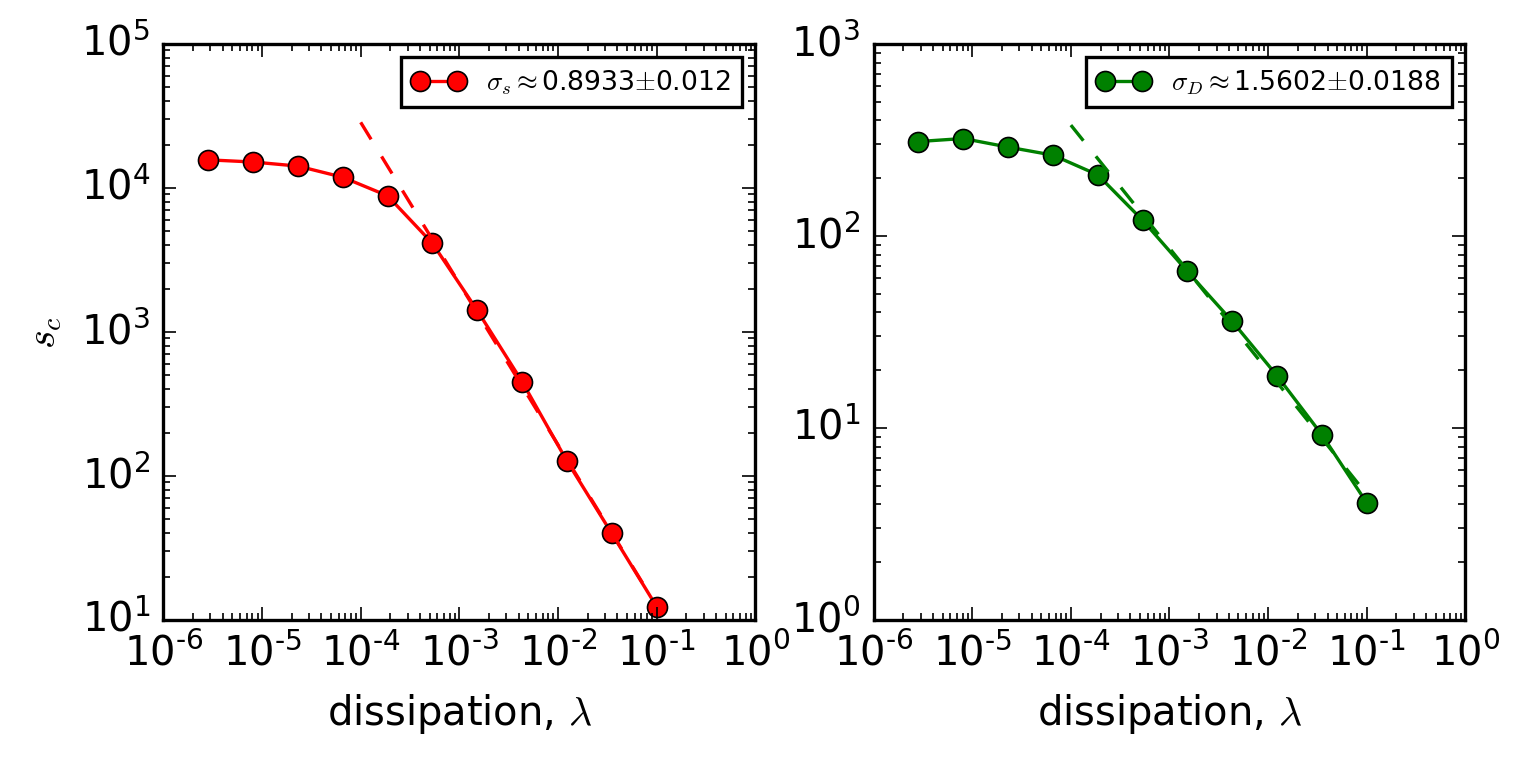

In [161]:
# ---------- Plot of Exponents while lambda -> 0 --------- #
# ---------- Fitting to compute \sigma's  ---------------- #

slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(np.log10(np.asarray(lambdas[0:-5])), np.log10(np.asarray(s_c[0:-5])))
slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(np.log10(np.asarray(lambdas[0:-5])), np.log10(np.asarray(d_c[0:-5])))

xs = np.linspace(-4,-1,7)
lineS = slopeS * xs + interceptS
lineD = slopeD * xs + interceptD

sigma_s = -1/slopeS
sigma_d = -1/slopeD
sigma_s_err = std_errS
sigma_d_err = std_errD

# -------------------- Create Figure  -------------------- #
fig2, (ax4, ax6) = plt.subplots(1,2,figsize=(7, 3), dpi=240, frameon=False)
ax4.plot(np.asarray(lambdas),np.asarray(s_c), 'ro-', 
         label=r'$\sigma_s \approx $' + str(round(-1/slopeS, 4)) + '$\pm$' + str(round(std_errS, 4)))
ax6.plot(np.asarray(lambdas),np.asarray(d_c),'go-', 
         label=r'$\sigma_D \approx $' + str(round(-1/slopeD, 4)) + '$\pm$' + str(round(std_errD, 4)))

# print(-1/slopeS, -1/slopeD)
ax4.plot(10**xs, 10**lineS, '--', color='red')
ax6.plot(10**xs, 10**lineD, '--', color='green')

# -- Decoration --
ax4.legend(fontsize=8); 
ax6.legend(fontsize=8); 
ax4.set_xscale('log'); ax4.set_yscale('log'); ax4.set_xlabel('dissipation, $\lambda$'); ax4.set_ylabel('$s_c$')
ax6.set_xscale('log'); ax6.set_yscale('log'); ax6.set_xlabel('dissipation, $\lambda$'); ax5.set_ylabel('$a_c$')
# fig2.suptitle("MM-OBC, $L=256$, $h_c = $"+str(h_c))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


## Plot distribution for finite-$\lambda$

The distribution is: 

$$ n_s \sim s^{-\tau} \exp[-s/s_c] \sim s^{-\tau} \exp\left[ -s / \lambda^{-1/\sigma} \right] $$

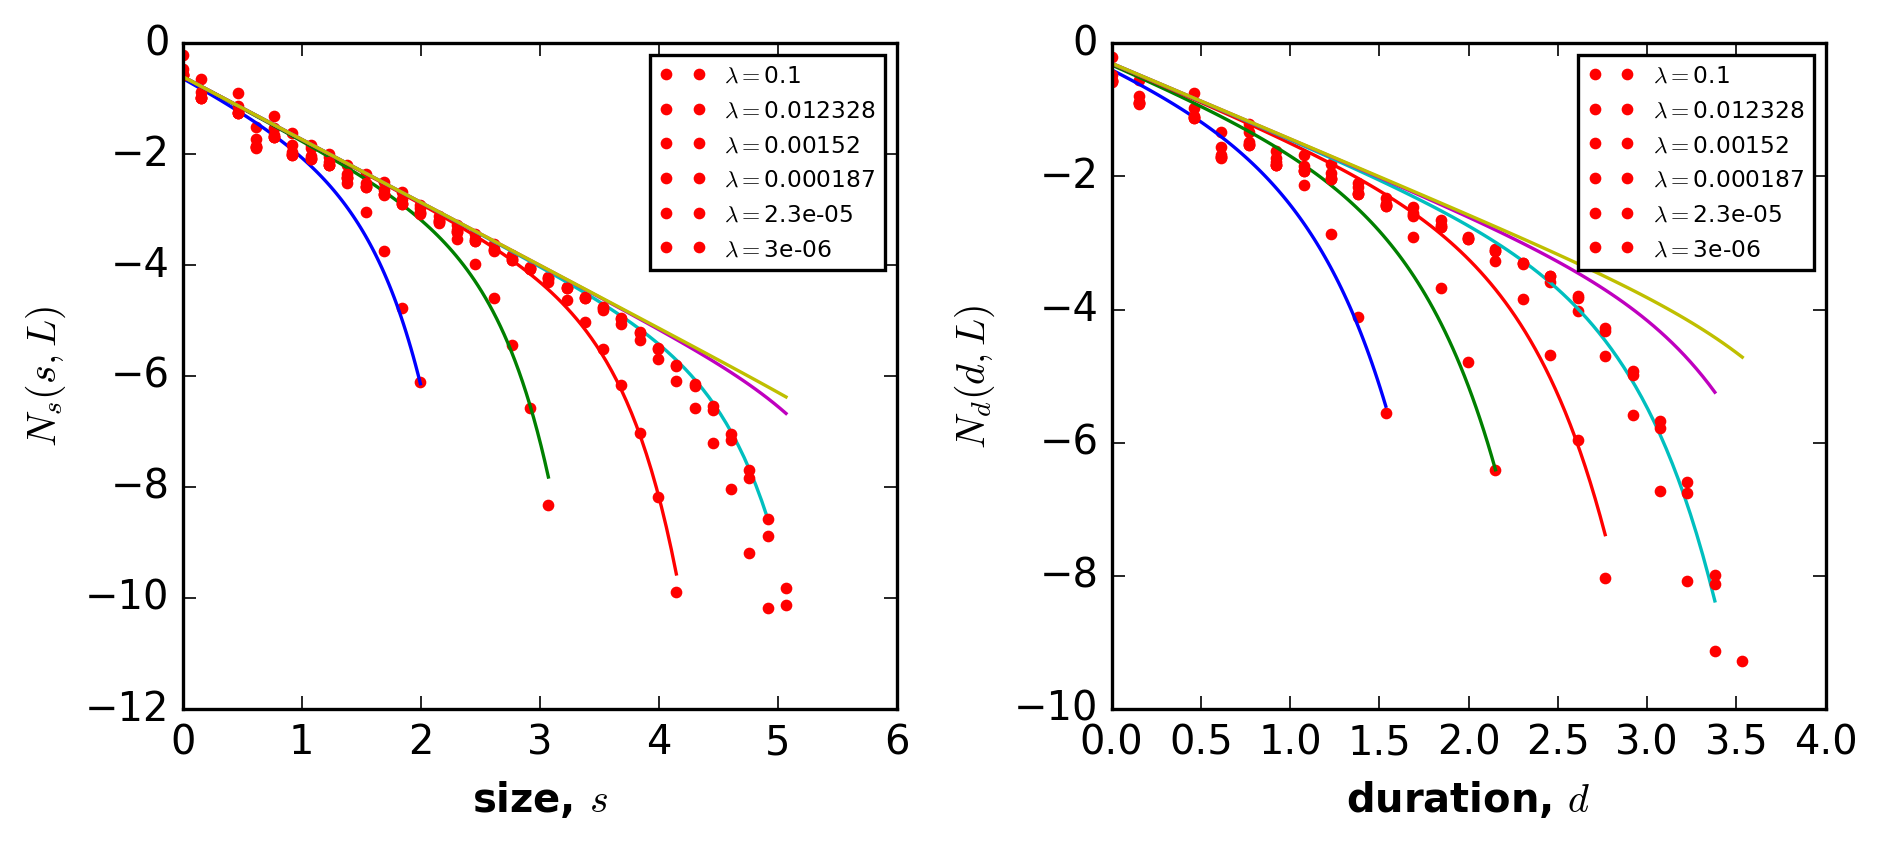

In [183]:
def func_size_theory_s(s, tau, sigma, lamb):
    return 0.25*s**(-tau) * np.exp(-s * lamb**(1/sigma))

def func_size_theory_d(s, tau, sigma, lamb):
    return 0.5*s**(-tau) * np.exp(-s * lamb**(1/sigma))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4), dpi=240, frameon=False)

for j in range(0,len(seedRange), 2): 
    seed0 = seedRange[j] # Run/seed with smallest \lambda
    print("Working on seed"+str(seed0)+"...", end='\r')

    ## Sizes w/ double counting
    x,y,params = plotSizes(seed0, filetype='s');  x = np.log10(x); y = np.log10(y)
    ax1.plot(x, y, '.', color=c, label = r"$\lambda=$"+str(round(params[2],6)))

    ### plotting the theoretic on top: 
    x_q = np.linspace(x[0], x[-1], 100)
    y_q = np.log10(func_size_theory_s(10**(x_q), tau_s, sigma_s, params[2]))
    ax1.plot(x_q, y_q)

    ## Durations
    x,y,params = plotSizes(seed0, filetype='d');  x = np.log10(x); y = np.log10(y)
    ax2.plot(x, y, '.', color=c,label = r"$\lambda=$"+str(round(params[2],6)))

    x_q = np.linspace(x[0], x[-1], 100)
    y_q = np.log10(func_size_theory_d(10**(x_q), tau_d, sigma_d, params[2]))
    ax2.plot(x_q, y_q)

# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=1, fontsize=7)
ax2.legend(loc=1, fontsize=7)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

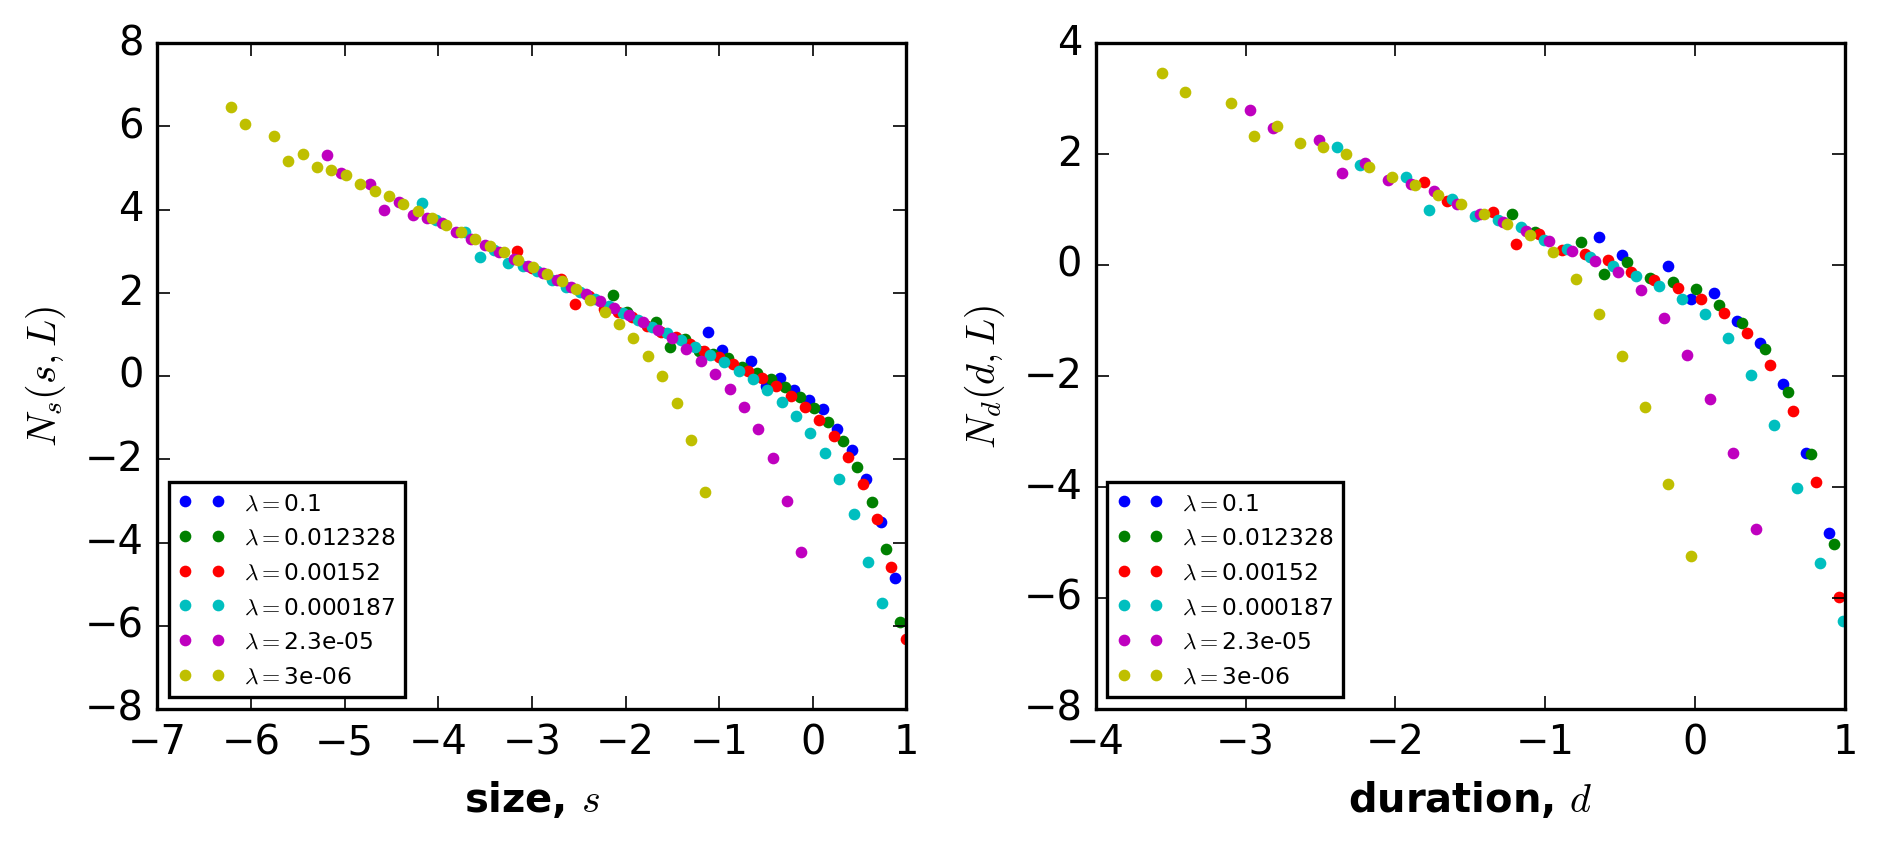

In [185]:
def func_size_theory(s, tau, sigma, lamb):
    return 0.25*s**(-tau) * np.exp(-s * lamb**(1/sigma))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4), dpi=240, frameon=False)

for j in range(0,len(seedRange), 2): 
    seed0 = seedRange[j] # Run/seed with smallest \lambda
    print("Working on seed"+str(seed0)+"...", end='\r')

    ## Sizes w/ double counting
    x,y,params = plotSizes(seed0, filetype='s');  
    x = np.log10(x * params[2]**(1/sigma_s)); 
    y = np.log10(y * params[2]**(-tau_s/sigma_s))
    ax1.plot(x, y, '.', label = r"$\lambda=$"+str(round(params[2],6)))

    ## Durations
    x,y,params = plotSizes(seed0, filetype='d');  
    x = np.log10(x * params[2]**(1/sigma_d)); 
    y = np.log10(y * params[2]**(-tau_d/sigma_d))
    ax2.plot(x, y, '.',label = r"$\lambda=$"+str(round(params[2],6)))

# -- Decoration --
ax1.set_ylabel(r'$N_s(s,L)$',fontweight='bold'); ax1.set_xlabel('size, $s$',fontweight='bold')
ax2.set_ylabel(r'$N_d(d,L)$',fontweight='bold'); ax2.set_xlabel('duration, $d$',fontweight='bold')
ax3.set_ylabel(r'$N_a(a,L)$',fontweight='bold'); ax3.set_xlabel('size, $a$',fontweight='bold')
ax1.legend(loc=3, fontsize=7)
ax2.legend(loc=3, fontsize=7)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])